# [Hands-On] Mastering LLaMA 1: A Complete Walkthrough from Scratch

- Author: Sangkeun Jung (hugmanskj@gmail.com)

> Educational Purpose

**Copyright**: All rights reserved

---

### Overview

This hands-on tutorial is designed for those who want to fully understand and master the LLaMA 1 architecture by building it from scratch. We'll break down every component of the model, covering the theory and practical implementation details, to provide a comprehensive guide from the very basics to the final construction.

Throughout this walkthrough, you will:
- Dive deep into the foundational concepts behind LLaMA 1, such as multi-head attention, feed-forward networks, and the SwiGLU activation function.
- Implement advanced techniques like Rotary Position Embedding (RoPE) and RMSNorm, which optimize performance and efficiency in large models.
- Explore LLaMA's key improvements over traditional transformer models, including how it achieves better scalability and efficiency.
- Verify the correctness of your custom implementation by comparing it to Hugging Face’s official LLaMA 1 model at a high-precision level.

By the end of this tutorial, you'll have a complete understanding of LLaMA 1’s architecture and how to implement it from scratch, making it a powerful resource for both learners and professionals looking to deepen their knowledge of large-scale language models.

---

We begin by implementing essential utility functions, such as data loading, model initialization, and training helper functions. These components will be reused across different experimental setups for consistency and efficiency.

In [1]:
## Importing Libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

## Hyperparameters and Configuration

In [2]:
# Modified hyperparameters
SEQUENCE_LENGTH = 64

EMBEDDING_DIM = 256
HIDDEN_DIM = 256

BATCH_SIZE = 512
EPOCHS = 1
LEARNING_RATE = 0.001
PRINT_EVERY = 1000
VALIDATION_SPLIT = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Data Preparation

We are using the TinyShakespeare dataset, a small character-level text corpus consisting of a subset of Shakespeare's plays. It's often used for testing sequence models, as it includes a rich set of vocabulary and provides a challenging task for next-character prediction.

In [3]:
## Utility Functions

def load_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return f.read()

def create_char_mappings(text):
    chars = sorted(list(set(text)))
    char_to_idx = {ch: i for i, ch in enumerate(chars)}
    idx_to_char = {i: ch for i, ch in enumerate(chars)}
    return chars, char_to_idx, idx_to_char

## Dataset

In [4]:
class CharDataset(Dataset):
    def __init__(self, text, seq_length, char_to_idx):
        self.text = text
        self.seq_length = seq_length
        self.char_to_idx = char_to_idx

    def __len__(self):
        return len(self.text) - self.seq_length

    def __getitem__(self, idx):
        x = [self.char_to_idx[ch] for ch in self.text[idx:idx+self.seq_length]]
        y = [self.char_to_idx[ch] for ch in self.text[idx+1:idx+self.seq_length+1]]
        return torch.tensor(x), torch.tensor(y)

In autoregressive modeling, each input sequence predicts the next token. For this dataset, the input is a sequence of characters from the text, and the target is the same sequence shifted by one character. This technique allows the model to learn sequential dependencies within the text.

In [5]:
def prepare_data(text, seq_length, batch_size, val_split):
    chars, char_to_idx, idx_to_char = create_char_mappings(text)

    # Split data into train and validation
    val_size = int(len(text) * val_split)
    train_text, val_text = text[:-val_size], text[-val_size:]

    train_dataset = CharDataset(train_text, seq_length, char_to_idx)
    val_dataset = CharDataset(val_text, seq_length, char_to_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, chars, char_to_idx, idx_to_char

In [6]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=19zosLuU0z4MxIMKbGVYEGlg52QyfbTIy' -O input.txt

--2025-03-12 04:46:18--  https://drive.google.com/uc?export=download&id=19zosLuU0z4MxIMKbGVYEGlg52QyfbTIy
Resolving drive.google.com (drive.google.com)... 172.217.25.174, 2404:6800:400a:80a::200e
Connecting to drive.google.com (drive.google.com)|172.217.25.174|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=19zosLuU0z4MxIMKbGVYEGlg52QyfbTIy&export=download [following]
--2025-03-12 04:46:18--  https://drive.usercontent.google.com/download?id=19zosLuU0z4MxIMKbGVYEGlg52QyfbTIy&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.161.225, 2404:6800:400a:80c::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.161.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [application/octet-stream]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  4.14MB/s    in 0.3s 

In [7]:
# Load the data
text = load_data('./input.txt')
train_loader, val_loader, chars, char_to_idx, idx_to_char = prepare_data(text, SEQUENCE_LENGTH, BATCH_SIZE, VALIDATION_SPLIT)
vocab_size = len(chars)

print(f"Total characters: {len(text)}")
print(f"Vocabulary size: {vocab_size}")
print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")

Total characters: 1115394
Vocabulary size: 65
Train dataset size: 1003791
Validation dataset size: 111475


## Data Visualization

In [8]:
# Function to convert index sequence to character sequence
def indices_to_text(indices, idx_to_char):
    return ''.join([idx_to_char[idx.item()] for idx in indices])

# Get a batch of data
dataiter = iter(train_loader)
batch_x, batch_y = next(dataiter)

print(f"Input shape: {batch_x.shape}")
print(f"Target shape: {batch_y.shape}")

# Print a few samples from the batch
num_samples = 3
for i in range(num_samples):
    print(f"Sample {i+1}: ------------------------------" )
    print("Input sequence :", indices_to_text(batch_x[i], idx_to_char).replace('\n',''))
    print("Target sequence:", indices_to_text(batch_y[i], idx_to_char).replace('\n',''))
    print()


Input shape: torch.Size([512, 64])
Target shape: torch.Size([512, 64])
Sample 1: ------------------------------
Input sequence :  betweenThe young'st and oldest thing.SICINIUS:This is most 
Target sequence: betweenThe young'st and oldest thing.SICINIUS:This is most l

Sample 2: ------------------------------
Input sequence : r of their idle dreamsAnd rack thee in their fancies.Welcome, 
Target sequence:  of their idle dreamsAnd rack thee in their fancies.Welcome, h

Sample 3: ------------------------------
Input sequence : enry from imprisonmentAnd see him seated in the regal throne.3
Target sequence: nry from imprisonmentAnd see him seated in the regal throne.3 



## Training Function

In [9]:
def train(model, dataloader, criterion, optimizer, device, epoch, step, log_interval=10):
    model.train()
    losses = []

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output, _ = model(x)
        loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
        loss.backward()
        optimizer.step()

        step += 1
        losses.append((step, epoch, loss.item()))

        if (batch + 1) % log_interval == 0:
            print(f'Epoch {epoch}, Step {step}, Batch {batch+1}/{len(dataloader)}, Loss: {loss.item():.4f}')

    return losses, step

In [10]:
def validate(model, dataloader, criterion, device, epoch, step):
    model.eval()
    losses = []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            losses.append((step, epoch, loss.item()))

    return losses

## Generation Function

In [11]:
def ___generate(model, char_to_idx, idx_to_char, start_char, max_length, device):
    model.eval()
    hidden = None
    current_char = start_char
    generated_text = current_char

    for _ in range(max_length):
        x = torch.tensor([[char_to_idx[current_char]]]).to(device)
        output, hidden = model(x, hidden)
        probs = torch.softmax(output[0, -1], dim=0)
        next_char_idx = torch.multinomial(probs, 1).item()
        current_char = idx_to_char[next_char_idx]
        generated_text += current_char

    return generated_text


In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs, log_interval=10):
    all_train_losses = []
    all_val_losses = []
    step = 0

    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch}/{epochs}")
        epoch_start_time = time.time()

        # Training phase
        epoch_train_losses, step = train(model, train_loader, criterion, optimizer, device, epoch, step, log_interval)
        all_train_losses.extend(epoch_train_losses)

        # Validation phase
        epoch_val_losses = validate(model, val_loader, criterion, device, epoch, step)
        all_val_losses.extend(epoch_val_losses)

        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch}/{epochs}, '
              f'Train Loss: {epoch_train_losses[-1][2]:.4f}, '
              f'Val Loss: {epoch_val_losses[-1][2]:.4f}, '
              f'Epoch Time: {epoch_time:.2f}s')

    # Create DataFrames after all epochs
    train_losses_df = pd.DataFrame(all_train_losses, columns=['step', 'epoch', 'loss_value'])
    val_losses_df = pd.DataFrame(all_val_losses, columns=['step', 'epoch', 'loss_value'])

    return model, train_losses_df, val_losses_df

In [13]:
def generate_text(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text
    hidden = None

    with torch.no_grad():
        for _ in range(max_length):
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output, hidden = model(x, hidden)
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [14]:
# Utiltiy functions

# Dictionary to store the losses from different models/configurations
loss_comparison_dict = {}

# Function to add and store losses from different models
def add_loss_to_comparison(model_name, train_losses_df, val_losses_df):
    """
    Adds training and validation losses from a model to the comparison dictionary.

    Args:
    - model_name (str): A name to identify the model (e.g., 'LSTM', 'LSTM with RMSNorm')
    - train_losses_df (DataFrame): DataFrame containing the training losses.
    - val_losses_df (DataFrame): DataFrame containing the validation losses.
    """
    loss_comparison_dict[model_name] = {
        'train': train_losses_df,
        'val': val_losses_df
    }

In [15]:
# Function to plot loss curves
def plot_loss(train_losses_df, val_losses_df):
    plt.figure(figsize=(10, 5))

    # Plot training losses
    for epoch in train_losses_df['epoch'].unique():
        epoch_train_losses = train_losses_df[train_losses_df['epoch'] == epoch]
        plt.plot(epoch_train_losses['step'], epoch_train_losses['loss_value'],
                 color='blue', alpha=0.3)

    # scatter training loss at the end of each epoch
    last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
    plt.scatter(last_train_losses['step'], last_train_losses['loss_value'],
                color='blue')

    # Plot and scatter validation loss at the end of each epoch
    last_val_losses = val_losses_df.groupby('epoch').last().reset_index()
    plt.plot(last_val_losses['step'], last_val_losses['loss_value'],
             color='orange', label='Validation Loss')
    plt.scatter(last_val_losses['step'], last_val_losses['loss_value'],
                color='orange')

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to print final loss values
def print_final_losses(train_losses_df, val_losses_df):
    print("Final Training Loss:", train_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])
    print("Final Validation Loss:", val_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])

In [16]:
# Function to plot loss curves for multiple models stored in loss_comparison_dict
def plot_loss_comparisons():
    """
    Plots the training and validation loss curves for multiple models added to the loss comparison dictionary.
    """
    plt.figure(figsize=(10, 5))

    # Get the last model in the dictionary
    last_model_name = list(loss_comparison_dict.keys())[-1]

    # Loop through each model in the loss dictionary
    for model_name, losses in loss_comparison_dict.items():
        train_losses_df = losses['train']
        val_losses_df = losses['val']

        # Plot training losses for each model
        plt.plot(train_losses_df['step'], train_losses_df['loss_value'],
                 label=f'{model_name}', linestyle='-', alpha=0.7)

        # scatter training loss at the end of each epoch
        last_train_losses = train_losses_df.groupby('epoch').last().reset_index()

        # Scatter normal points for all models
        plt.scatter(last_train_losses['step'], last_train_losses['loss_value'], marker='o', s=50)

        # If this is the last model, highlight the last point with a star (no label in legend)
        if model_name == last_model_name:
            final_step = train_losses_df['step'].iloc[-1]
            final_loss = train_losses_df['loss_value'].iloc[-1]
            plt.scatter(final_step, final_loss, marker='*', s=100, color='red', zorder=5)  # Reduced size to s=100

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()  # Legend will only show colors, no final star
    plt.grid(True)
    plt.show()


We have prepared the data and utility functions, let’s implement a simple LSTM-based decoder as a baseline.

This is a foundational model that we’ll use to compare with more advanced architectures like LLaMA. The LSTM decoder will serve as a reference point in terms of performance and complexity.

If you're already familiar with LSTM models, you can skip this section and proceed directly to LLaMA-specific techniques.

---

## LSTM based Decoder

In [17]:
class LSTMDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LSTMDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        embed = self.embedding(x)
        output, hidden = self.lstm(embed, hidden)
        output = self.fc(output)
        return output, hidden

In [18]:
### Model Initialization
model = LSTMDecoder(vocab_size, EMBEDDING_DIM, HIDDEN_DIM).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [19]:
## Training Loop
trained_model, train_losses_df, val_losses_df = train_model(model, train_loader, val_loader, criterion, optimizer, device, EPOCHS)


Epoch 1/1
Epoch 1, Step 10, Batch 10/1961, Loss: 3.2304
Epoch 1, Step 20, Batch 20/1961, Loss: 2.8573
Epoch 1, Step 30, Batch 30/1961, Loss: 2.6259
Epoch 1, Step 40, Batch 40/1961, Loss: 2.4946
Epoch 1, Step 50, Batch 50/1961, Loss: 2.3762
Epoch 1, Step 60, Batch 60/1961, Loss: 2.3086
Epoch 1, Step 70, Batch 70/1961, Loss: 2.2409
Epoch 1, Step 80, Batch 80/1961, Loss: 2.1753
Epoch 1, Step 90, Batch 90/1961, Loss: 2.1291
Epoch 1, Step 100, Batch 100/1961, Loss: 2.0846
Epoch 1, Step 110, Batch 110/1961, Loss: 2.0432
Epoch 1, Step 120, Batch 120/1961, Loss: 1.9927
Epoch 1, Step 130, Batch 130/1961, Loss: 1.9800
Epoch 1, Step 140, Batch 140/1961, Loss: 1.9676
Epoch 1, Step 150, Batch 150/1961, Loss: 1.9188
Epoch 1, Step 160, Batch 160/1961, Loss: 1.9018
Epoch 1, Step 170, Batch 170/1961, Loss: 1.8639
Epoch 1, Step 180, Batch 180/1961, Loss: 1.8481
Epoch 1, Step 190, Batch 190/1961, Loss: 1.8333
Epoch 1, Step 200, Batch 200/1961, Loss: 1.7992
Epoch 1, Step 210, Batch 210/1961, Loss: 1.8131


In [20]:
# Text generation using validation data
val_sample, _ = next(iter(val_loader))
start_text = ''.join([idx_to_char[idx.item()] for idx in val_sample[0][:SEQUENCE_LENGTH]])
generated_text = generate_text(trained_model, char_to_idx, idx_to_char, start_text, device)
print(f"Generated text (starting with validation data [{start_text}]):")
print("-"*50)
print(generated_text)

Generated text (starting with validation data [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro]):
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow.

MONTAGUE:
To him, Romeo
shall it with palace; there he, a babe mind toward:
Lest. Here's hence, sometings of his errow.

ESCALUS:
Ay, gentlemen, my cilizenly weeds and Decusence
Teprenows to keep me no fay thee raised to his people,
Wloutry flat?

ESCALUS:
Good more.
Pretty God, yield ye father, thou shalt as aire.

SMance I Citizen:
More answer to perform'd fenter?

CAMILLO:
Is they do you so to the Chriscolus; for scorn with us,
And, gillop, as you gave in resid.

CAPULET:
Said, Juliet unt


The generated text demonstrates that the model has learned some structure, but the coherence is still lacking.

It can form character strings that resemble English but doesn’t create meaningful sentences. This is typical for early-stage character-level models, which struggle to capture long-term dependencies.

In [21]:
# After training a model (e.g., LSTM without RMSNorm), add its losses
add_loss_to_comparison('LSTM', train_losses_df, val_losses_df)

In [22]:
# Decoder Input/Output Example
sample_input, _ = next(iter(val_loader))
sample_input = sample_input[0].unsqueeze(0).to(device)  # Add batch dimension

trained_model.eval()
with torch.no_grad():
    output, _ = trained_model(sample_input)

print("\nSample Input:")
print(''.join([idx_to_char[idx.item()] for idx in sample_input[0]]))

print("\nModel Output (logits for next character prediction):")
print(output.shape)
print(output[0, 0, :10])  # Print first 10 logits of the first timestep

print("\nPredicted next character:")
predicted_char_idx = torch.argmax(output[0, -1]).item()
print(idx_to_char[predicted_char_idx])


Sample Input:


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro

Model Output (logits for next character prediction):
torch.Size([1, 64, 65])
tensor([ 4.4224, -1.0512, -2.3928, -2.8947, -2.4501,  1.2683, -3.3224, -1.6603,
        -2.3983, -0.2867], device='cuda:0')

Predicted next character:
w


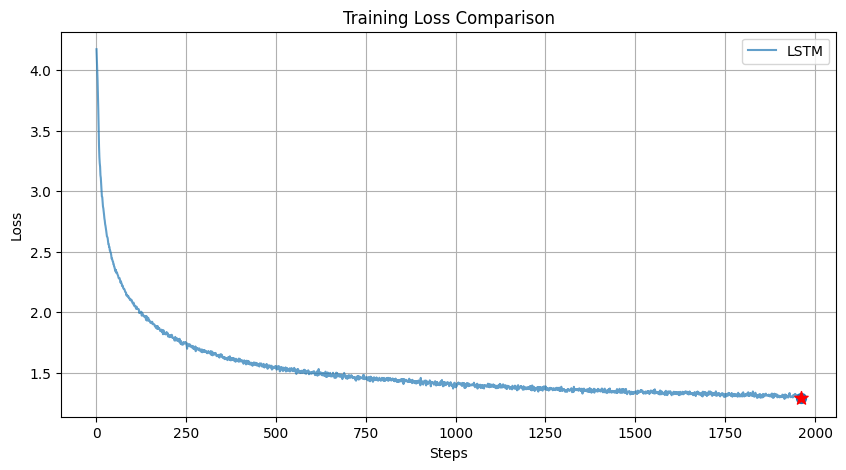

In [23]:
# After you've added multiple models, plot the comparison
plot_loss_comparisons()

----


We now transition to the core LLaMA components.

From this point, we’ll begin building the essential structures of LLaMA, starting with simple single-head attention-based decoders. We will progressively add complexity to the model, block by block, to achieve a full implementation of LLaMA 1.

Here’s an overview of the steps we’ll follow to build the complete model:

1. **Single-Head Attention Decoder**:
   - We start with a basic single-head attention mechanism to familiarize ourselves with attention layers.
   - This will serve as a foundational block for more complex attention architectures.

2. **Positional Encoding**:
   - To provide the model with an understanding of token order, we will add learnable positional embeddings, helping the model understand sequence order and relationships.

3. **Look-Ahead Masking**:
   - To prevent the model from seeing future tokens during training, we’ll implement look-ahead masking, ensuring proper autoregressive behavior.

4. **Layer Normalization (LayerNorm)**:
   - We’ll introduce LayerNorm, which stabilizes the training process by normalizing the outputs of each layer, improving convergence.

5. **RMSNorm**:
   - Next, we’ll swap out LayerNorm with RMSNorm, a more efficient normalization technique used in LLaMA for larger model scalability and better computational efficiency.

6. **Residual Connections**:
   - Adding residual connections to preserve important information and prevent the degradation of signals as they pass through multiple layers.

7. **Feed-Forward Networks (FFNs)**:
   - We’ll introduce traditional feed-forward layers, followed by LLaMA’s more advanced SwiGLU activation-based feed-forward network, which allows for efficient representation mixing.

8. **Rotary Position Embedding (RoPE)**:
   - We’ll enhance the model’s ability to capture positional information by replacing the learnable positional embeddings with Rotary Position Embedding (RoPE), improving the model’s handling of longer sequences.

9. **Multi-Head Attention (MHA)**:
   - To scale the attention mechanism, we’ll move from single-head to multi-head attention, allowing the model to attend to multiple parts of the sequence simultaneously.

10. **Stacking Layers**:
    - Finally, we will scale the architecture by stacking multiple layers, creating a multi-layer transformer with multi-head attention and feed-forward networks, which is the backbone of the LLaMA architecture.

11. **Final Verification**:
    - Once all components are in place, we’ll compare our custom implementation with Hugging Face's official LLaMA 1 model, ensuring that our implementation is accurate and produces identical results in a high-precision environment.

---


# Simple Single-Head Attention-Based Decoder

In this section, we implement a basic single-head attention mechanism as a step towards LLaMA.

Attention mechanisms allow models to focus on specific parts of the input sequence when generating predictions, improving the ability to capture relationships between distant tokens.

In [24]:
import torch
import torch.nn.functional as F

# Single-Head Attention (Very Basic)
class SingleHeadAttention(nn.Module):
    def __init__(self, d_model, seq_length):
        super(SingleHeadAttention, self).__init__()
        self.d_model = d_model
        self.seq_length = seq_length

        self.query = nn.Linear(d_model, d_model, bias=False)
        self.key = nn.Linear(d_model, d_model, bias=False)
        self.value = nn.Linear(d_model, d_model, bias=False)
        self.fc_out = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Scaled dot-product attention
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_model ** 0.5)

        attention_probs = F.softmax(attention_scores, dim=-1)
        attention_output = torch.matmul(attention_probs, V)

        return self.fc_out(attention_output)


# LLaMA Decoder Layer
class LLaMADecoderLayer(nn.Module):
    def __init__(self, embedding_dim, seq_length):
        super(LLaMADecoderLayer, self).__init__()
        self.attention = SingleHeadAttention(embedding_dim, seq_length)

    def forward(self, x):
        attention_output = self.attention(x)
        return attention_output


class LLaMAModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, seq_length):
        super(LLaMAModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.layer = LLaMADecoderLayer(embedding_dim, seq_length)
        self.fc_out = nn.Linear(embedding_dim, vocab_size, bias=False) # lm_head

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.layer(x)
        logits = self.fc_out(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
            return logits, loss
        return logits, None

For this initial implementation, we employ a simple approach to text generation using single-head attention.

Although there are more sophisticated generation methods, this basic version will allow us to observe the performance of the model with attention mechanisms in place.

In [25]:
def generate_text_attention(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text

    with torch.no_grad():
        for _ in range(max_length):
            # Convert the last sequence of characters to indices and feed it to the model
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output = model(x)[0]  # No hidden state needed for attention-based models
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [26]:
def train_and_test(model_desc, start_text):
    # Initialize the model
    model_llama = LLaMAModel(vocab_size, EMBEDDING_DIM, SEQUENCE_LENGTH).to(device)

    # Use the same optimizer and criterion
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model_llama.parameters(), lr=LEARNING_RATE)

    # Train the model
    trained_model, train_losses_df, val_losses_df = train_model(
        model_llama, train_loader, val_loader, criterion, optimizer, device, EPOCHS
    )

    # Generate text
    generated_text = generate_text_attention(trained_model, char_to_idx, idx_to_char, start_text, device)
    print(f"Generated text [{start_text}]:")
    print("-"*50)
    print(generated_text)

    add_loss_to_comparison(model_desc, train_losses_df, val_losses_df)

    # Plot loss comparisons including this model
    plot_loss_comparisons()

Epoch 1/1
Epoch 1, Step 10, Batch 10/1961, Loss: 3.1766
Epoch 1, Step 20, Batch 20/1961, Loss: 2.9099
Epoch 1, Step 30, Batch 30/1961, Loss: 2.7753
Epoch 1, Step 40, Batch 40/1961, Loss: 2.6829
Epoch 1, Step 50, Batch 50/1961, Loss: 2.6332
Epoch 1, Step 60, Batch 60/1961, Loss: 2.6237
Epoch 1, Step 70, Batch 70/1961, Loss: 2.6015
Epoch 1, Step 80, Batch 80/1961, Loss: 2.5741
Epoch 1, Step 90, Batch 90/1961, Loss: 2.5526
Epoch 1, Step 100, Batch 100/1961, Loss: 2.5232
Epoch 1, Step 110, Batch 110/1961, Loss: 2.5139
Epoch 1, Step 120, Batch 120/1961, Loss: 2.5176
Epoch 1, Step 130, Batch 130/1961, Loss: 2.4972
Epoch 1, Step 140, Batch 140/1961, Loss: 2.4809
Epoch 1, Step 150, Batch 150/1961, Loss: 2.4870
Epoch 1, Step 160, Batch 160/1961, Loss: 2.4770
Epoch 1, Step 170, Batch 170/1961, Loss: 2.4790
Epoch 1, Step 180, Batch 180/1961, Loss: 2.4675
Epoch 1, Step 190, Batch 190/1961, Loss: 2.4593
Epoch 1, Step 200, Batch 200/1961, Loss: 2.4530
Epoch 1, Step 210, Batch 210/1961, Loss: 2.4452


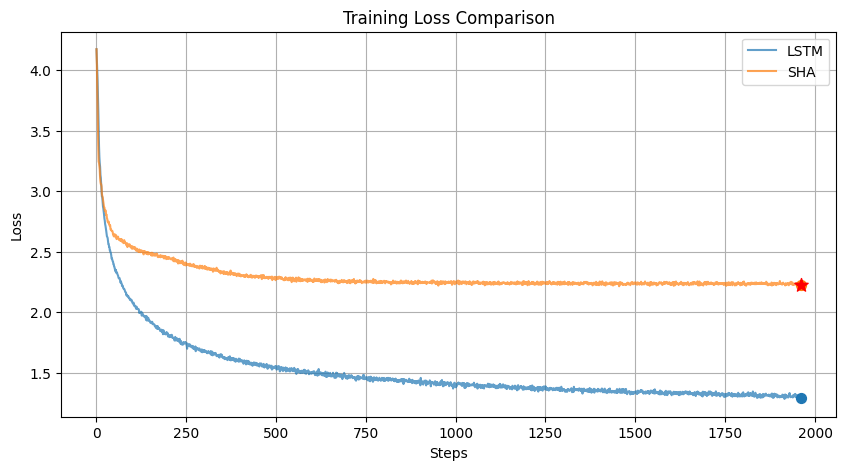

In [27]:
train_and_test("SHA", start_text)

The performance of this simple attention model lags behind the LSTM model. There are several reasons for this:
- Lack of positional encoding, which hinders the model’s ability to understand the sequence order.
- Single-head attention may not capture sufficient complexity in relationships between tokens.
- Basic architecture without residual connections or normalization can limit model performance.

## SHA + Positional Encoding

Unlike LSTM models, attention-based models do not inherently understand the order of tokens. To address this, we introduce positional encoding, which provides the model with information about the sequence order. In this case, we use a learnable positional embedding, similar to how BERT models incorporate positional information.

In [28]:
import torch
import torch.nn.functional as F

class SingleHeadAttention(nn.Module):
    def __init__(self, d_model, seq_length):
        super(SingleHeadAttention, self).__init__()
        self.d_model = d_model
        self.seq_length = seq_length

        self.query = nn.Linear(d_model, d_model, bias=False)
        self.key = nn.Linear(d_model, d_model, bias=False)
        self.value = nn.Linear(d_model, d_model, bias=False)
        self.fc_out = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Scaled dot-product attention
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_model ** 0.5)

        attention_probs = F.softmax(attention_scores, dim=-1)
        attention_output = torch.matmul(attention_probs, V)

        return self.fc_out(attention_output)


# LLaMA Decoder Layer
class LLaMADecoderLayer(nn.Module):
    def __init__(self, embedding_dim, seq_length):
        super(LLaMADecoderLayer, self).__init__()
        self.attention = SingleHeadAttention(embedding_dim, seq_length)

    def forward(self, x):
        attention_output = self.attention(x)
        return attention_output

class LLaMAModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, seq_length):
        super(LLaMAModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.layer = LLaMADecoderLayer(embedding_dim, seq_length)
        self.fc_out = nn.Linear(embedding_dim, vocab_size, bias=False) # lm_head

        # Learnable Positional Embedding
        self.positional_embedding = nn.Embedding(seq_length, embedding_dim)


    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        # Add positional embeddings to input embeddings
        seq_positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)  # Create position indices
        x = x + self.positional_embedding(seq_positions)

        x = self.layer(x)
        logits = self.fc_out(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
            return logits, loss
        return logits, None

Epoch 1/1
Epoch 1, Step 10, Batch 10/1961, Loss: 3.1153
Epoch 1, Step 20, Batch 20/1961, Loss: 2.8396
Epoch 1, Step 30, Batch 30/1961, Loss: 2.7101
Epoch 1, Step 40, Batch 40/1961, Loss: 2.6470
Epoch 1, Step 50, Batch 50/1961, Loss: 2.3279
Epoch 1, Step 60, Batch 60/1961, Loss: 0.6232
Epoch 1, Step 70, Batch 70/1961, Loss: 0.1309
Epoch 1, Step 80, Batch 80/1961, Loss: 0.0724
Epoch 1, Step 90, Batch 90/1961, Loss: 0.0630
Epoch 1, Step 100, Batch 100/1961, Loss: 0.0567
Epoch 1, Step 110, Batch 110/1961, Loss: 0.0526
Epoch 1, Step 120, Batch 120/1961, Loss: 0.0523
Epoch 1, Step 130, Batch 130/1961, Loss: 0.0508
Epoch 1, Step 140, Batch 140/1961, Loss: 0.0511
Epoch 1, Step 150, Batch 150/1961, Loss: 0.0475
Epoch 1, Step 160, Batch 160/1961, Loss: 0.0473
Epoch 1, Step 170, Batch 170/1961, Loss: 0.0469
Epoch 1, Step 180, Batch 180/1961, Loss: 0.0470
Epoch 1, Step 190, Batch 190/1961, Loss: 0.0460
Epoch 1, Step 200, Batch 200/1961, Loss: 0.0471
Epoch 1, Step 210, Batch 210/1961, Loss: 0.0479


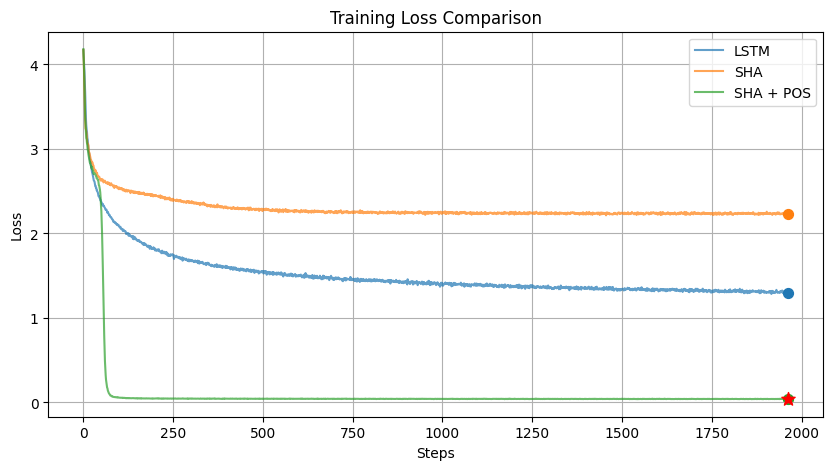

In [29]:
train_and_test("SHA + POS", start_text)

The generated results might look reasonable, but this is due to the model 'cheating.' In self-attention mechanisms without masking, the model sees the entire sequence, including future tokens, during training. As a result, it can predict the next token based on information it shouldn't have access to, leading to unrealistic results. To prevent this, we need to implement 'look-ahead masking.'

In [30]:
# Let's remove the not-masking version
del loss_comparison_dict["SHA + POS"] # no need to compare anymore

## Single-Head-Attention + Masking

Look-ahead masking ensures that when predicting the next token, the model only considers tokens that come before the current position. This prevents the model from 'cheating' by looking ahead at future tokens during the training phase. It's crucial for autoregressive generation in transformer models.

In [31]:
import torch
import torch.nn.functional as F

class SingleHeadAttention(nn.Module):
    def __init__(self, d_model, seq_length):
        super(SingleHeadAttention, self).__init__()
        self.d_model = d_model
        self.seq_length = seq_length

        self.query = nn.Linear(d_model, d_model, bias=False)
        self.key = nn.Linear(d_model, d_model, bias=False)
        self.value = nn.Linear(d_model, d_model, bias=False)
        self.fc_out = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x, mask=None):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Scaled dot-product attention
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_model ** 0.5)

        # look-ahead masking!
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))

        attention_probs = F.softmax(attention_scores, dim=-1)
        attention_output = torch.matmul(attention_probs, V)

        return self.fc_out(attention_output)


# LLaMA Decoder Layer
class LLaMADecoderLayer(nn.Module):
    def __init__(self, embedding_dim, seq_length):
        super(LLaMADecoderLayer, self).__init__()
        self.attention = SingleHeadAttention(embedding_dim, seq_length)

    def forward(self, x, mask):
        attention_output = self.attention(x, mask)
        return attention_output


# LLaMA Model with RoPE and Multi-Layer
class LLaMAModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, seq_length):
        super(LLaMAModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.layer = LLaMADecoderLayer(embedding_dim, seq_length)
        self.fc_out = nn.Linear(embedding_dim, vocab_size, bias=False) # lm_head

        # Learnable Positional Embedding
        self.positional_embedding = nn.Embedding(seq_length, embedding_dim)

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        # Add positional embeddings to input embeddings
        seq_positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)  # Create position indices
        x = x + self.positional_embedding(seq_positions)

        # Look-Ahead Masking
        seq_length = x.size(1)
        mask = torch.tril(torch.ones(seq_length, seq_length)).to(x.device)

        x = self.layer(x, mask)
        logits = self.fc_out(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
            return logits, loss
        return logits, None

Epoch 1/1
Epoch 1, Step 10, Batch 10/1961, Loss: 3.1469
Epoch 1, Step 20, Batch 20/1961, Loss: 2.9177
Epoch 1, Step 30, Batch 30/1961, Loss: 2.7921
Epoch 1, Step 40, Batch 40/1961, Loss: 2.7189
Epoch 1, Step 50, Batch 50/1961, Loss: 2.6726
Epoch 1, Step 60, Batch 60/1961, Loss: 2.6233
Epoch 1, Step 70, Batch 70/1961, Loss: 2.6009
Epoch 1, Step 80, Batch 80/1961, Loss: 2.5656
Epoch 1, Step 90, Batch 90/1961, Loss: 2.5423
Epoch 1, Step 100, Batch 100/1961, Loss: 2.5206
Epoch 1, Step 110, Batch 110/1961, Loss: 2.5002
Epoch 1, Step 120, Batch 120/1961, Loss: 2.4676
Epoch 1, Step 130, Batch 130/1961, Loss: 2.4487
Epoch 1, Step 140, Batch 140/1961, Loss: 2.4223
Epoch 1, Step 150, Batch 150/1961, Loss: 2.3819
Epoch 1, Step 160, Batch 160/1961, Loss: 2.3927
Epoch 1, Step 170, Batch 170/1961, Loss: 2.3489
Epoch 1, Step 180, Batch 180/1961, Loss: 2.3325
Epoch 1, Step 190, Batch 190/1961, Loss: 2.3338
Epoch 1, Step 200, Batch 200/1961, Loss: 2.3138
Epoch 1, Step 210, Batch 210/1961, Loss: 2.3196


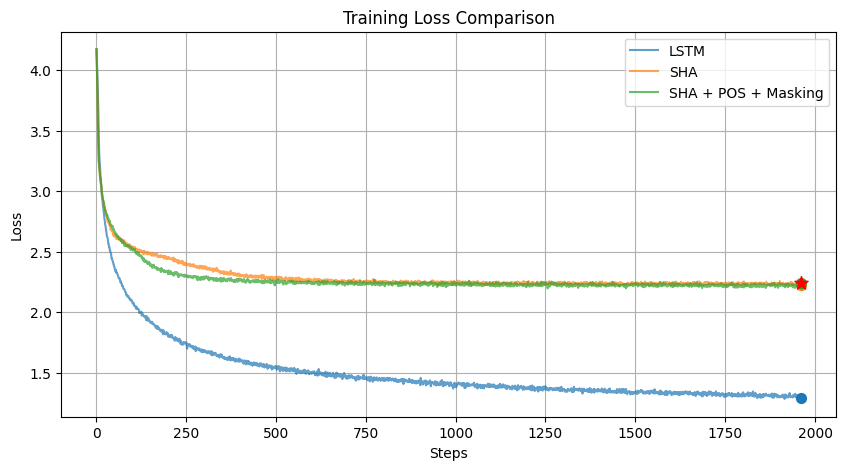

In [32]:
train_and_test("SHA + POS + Masking", start_text)

With look-ahead masking, we obtain more *realistic* performance curves. This method ensures the model no longer has access to future tokens, providing a more challenging, yet authentic, learning task. We now begin to observe the expected loss behavior.

## SHA + POS + Masking + Norm(LayerNorm)

Next, we introduce normalization layers into the model. Layer normalization (LayerNorm) stabilizes the training process by normalizing the output of each layer, preventing issues such as exploding or vanishing gradients. We apply LayerNorm before and after the attention mechanism and the feed-forward layer.

In [33]:
import torch
import torch.nn.functional as F

class SingleHeadAttention(nn.Module):
    def __init__(self, d_model, seq_length):
        super(SingleHeadAttention, self).__init__()
        self.d_model = d_model
        self.seq_length = seq_length

        self.query = nn.Linear(d_model, d_model, bias=False)
        self.key = nn.Linear(d_model, d_model, bias=False)
        self.value = nn.Linear(d_model, d_model, bias=False)
        self.fc_out = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x, mask=None):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Scaled dot-product attention
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_model ** 0.5)

        # look-ahead masking!
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))

        attention_probs = F.softmax(attention_scores, dim=-1)
        attention_output = torch.matmul(attention_probs, V)

        return self.fc_out(attention_output)


# LLaMA Decoder Layer
class LLaMADecoderLayer(nn.Module):
    def __init__(self, embedding_dim, seq_length):
        super(LLaMADecoderLayer, self).__init__()
        self.attention = SingleHeadAttention(embedding_dim, seq_length)
        self.layernorm1 = nn.LayerNorm(embedding_dim) # pre-norm
        self.layernorm2 = nn.LayerNorm(embedding_dim) # post-norm

    def forward(self, x, mask):
        # Pre-Norm
        normed_x = self.layernorm1(x)

        # Attention
        attention_output = self.attention(normed_x, mask)

        # Post-Norm
        normed_x = self.layernorm2(attention_output)

        return x

class LLaMAModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, seq_length):
        super(LLaMAModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.layer = LLaMADecoderLayer(embedding_dim, seq_length)
        self.fc_out = nn.Linear(embedding_dim, vocab_size, bias=False) # lm_head

        # final norm after top-layer
        self.layernorm3 = nn.LayerNorm(embedding_dim) # final-norm

        # Learnable Positional Embedding
        self.positional_embedding = nn.Embedding(seq_length, embedding_dim)

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        # Add positional embeddings to input embeddings
        seq_positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)  # Create position indices
        x = x + self.positional_embedding(seq_positions)

        # Look-Ahead Masking
        seq_length = x.size(1)
        mask = torch.tril(torch.ones(seq_length, seq_length)).to(x.device)

        x = self.layer(x, mask)

        # Normalization
        x = self.layernorm3(x)

        logits = self.fc_out(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
            return logits, loss
        return logits, None

Epoch 1/1


Epoch 1, Step 10, Batch 10/1961, Loss: 3.7850
Epoch 1, Step 20, Batch 20/1961, Loss: 3.3510
Epoch 1, Step 30, Batch 30/1961, Loss: 3.0692
Epoch 1, Step 40, Batch 40/1961, Loss: 2.8865
Epoch 1, Step 50, Batch 50/1961, Loss: 2.7775
Epoch 1, Step 60, Batch 60/1961, Loss: 2.7035
Epoch 1, Step 70, Batch 70/1961, Loss: 2.6520
Epoch 1, Step 80, Batch 80/1961, Loss: 2.6131
Epoch 1, Step 90, Batch 90/1961, Loss: 2.5760
Epoch 1, Step 100, Batch 100/1961, Loss: 2.5590
Epoch 1, Step 110, Batch 110/1961, Loss: 2.5536
Epoch 1, Step 120, Batch 120/1961, Loss: 2.5339
Epoch 1, Step 130, Batch 130/1961, Loss: 2.5207
Epoch 1, Step 140, Batch 140/1961, Loss: 2.5216
Epoch 1, Step 150, Batch 150/1961, Loss: 2.5094
Epoch 1, Step 160, Batch 160/1961, Loss: 2.5191
Epoch 1, Step 170, Batch 170/1961, Loss: 2.4957
Epoch 1, Step 180, Batch 180/1961, Loss: 2.5050
Epoch 1, Step 190, Batch 190/1961, Loss: 2.4880
Epoch 1, Step 200, Batch 200/1961, Loss: 2.4893
Epoch 1, Step 210, Batch 210/1961, Loss: 2.4834
Epoch 1, S

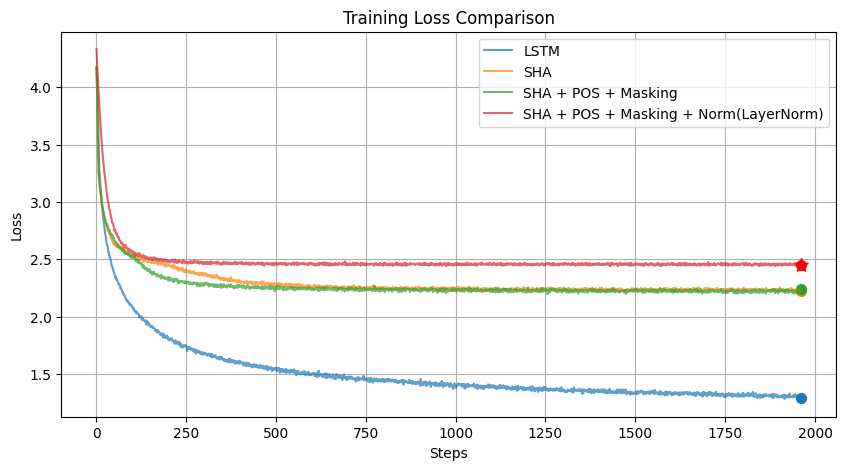

In [34]:
train_and_test("SHA + POS + Masking + Norm(LayerNorm)", start_text)

## SHA + POS + Masking + Norm(RMSNorm)

RMSNorm is a variation of LayerNorm that is more efficient for certain architectures, such as LLaMA. Instead of normalizing across all dimensions, it normalizes only across the root mean square of the dimensions, improving stability in large models. We now replace LayerNorm with RMSNorm for comparison.

In [35]:
import torch
import torch.nn.functional as F

class SingleHeadAttention(nn.Module):
    def __init__(self, d_model, seq_length):
        super(SingleHeadAttention, self).__init__()
        self.d_model = d_model
        self.seq_length = seq_length

        self.query = nn.Linear(d_model, d_model, bias=False)
        self.key = nn.Linear(d_model, d_model, bias=False)
        self.value = nn.Linear(d_model, d_model, bias=False)
        self.fc_out = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x, mask=None):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Scaled dot-product attention
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_model ** 0.5)

        # look-ahead masking!
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))

        attention_probs = F.softmax(attention_scores, dim=-1)
        attention_output = torch.matmul(attention_probs, V)

        return self.fc_out(attention_output)


# Custom RMSNorm to match LLaMA 1 official implementation
class RMSNorm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super(RMSNorm, self).__init__()
        self.weight = nn.Parameter(torch.ones(d_model))
        self.eps = eps

    def _norm(self, x):
        # Compute variance and apply reciprocal square root for RMS normalization
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        # Convert to float32 for precision, then back to original dtype
        output = self._norm(x.float()).type_as(x)
        return output * self.weight


# LLaMA Decoder Layer
class LLaMADecoderLayer(nn.Module):
    def __init__(self, embedding_dim, seq_length):
        super(LLaMADecoderLayer, self).__init__()
        self.attention = SingleHeadAttention(embedding_dim, seq_length)
        self.rmsnorm1 = RMSNorm(embedding_dim) # pre-norm
        self.rmsnorm2 = RMSNorm(embedding_dim) # post-norm

    def forward(self, x, mask):
        # Pre-Norm
        normed_x = self.rmsnorm1(x)

        # Attention
        attention_output = self.attention(normed_x, mask)

        # Post-Norm
        normed_x = self.rmsnorm2(attention_output)

        return normed_x

class LLaMAModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, seq_length):
        super(LLaMAModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.layer = LLaMADecoderLayer(embedding_dim, seq_length)
        self.fc_out = nn.Linear(embedding_dim, vocab_size, bias=False) # lm_head

        self.rmsnorm_f = RMSNorm(embedding_dim) # final_norm

        # Learnable Positional Embedding
        self.positional_embedding = nn.Embedding(seq_length, embedding_dim)

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        # Add positional embeddings to input embeddings
        seq_positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)  # Create position indices
        x = x + self.positional_embedding(seq_positions)

        # Look-Ahead Masking
        seq_length = x.size(1)
        mask = torch.tril(torch.ones(seq_length, seq_length)).to(x.device)

        x = self.layer(x, mask)

        # final norm
        x = self.rmsnorm_f(x)

        logits = self.fc_out(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
            return logits, loss
        return logits, None

Epoch 1/1
Epoch 1, Step 10, Batch 10/1961, Loss: 3.0695
Epoch 1, Step 20, Batch 20/1961, Loss: 2.8653
Epoch 1, Step 30, Batch 30/1961, Loss: 2.7607
Epoch 1, Step 40, Batch 40/1961, Loss: 2.6893
Epoch 1, Step 50, Batch 50/1961, Loss: 2.6423
Epoch 1, Step 60, Batch 60/1961, Loss: 2.6026
Epoch 1, Step 70, Batch 70/1961, Loss: 2.5675
Epoch 1, Step 80, Batch 80/1961, Loss: 2.5578
Epoch 1, Step 90, Batch 90/1961, Loss: 2.5070
Epoch 1, Step 100, Batch 100/1961, Loss: 2.4665
Epoch 1, Step 110, Batch 110/1961, Loss: 2.4165
Epoch 1, Step 120, Batch 120/1961, Loss: 2.3802
Epoch 1, Step 130, Batch 130/1961, Loss: 2.3590
Epoch 1, Step 140, Batch 140/1961, Loss: 2.3399
Epoch 1, Step 150, Batch 150/1961, Loss: 2.3345
Epoch 1, Step 160, Batch 160/1961, Loss: 2.3278
Epoch 1, Step 170, Batch 170/1961, Loss: 2.3116
Epoch 1, Step 180, Batch 180/1961, Loss: 2.2996
Epoch 1, Step 190, Batch 190/1961, Loss: 2.3002
Epoch 1, Step 200, Batch 200/1961, Loss: 2.2974
Epoch 1, Step 210, Batch 210/1961, Loss: 2.2880


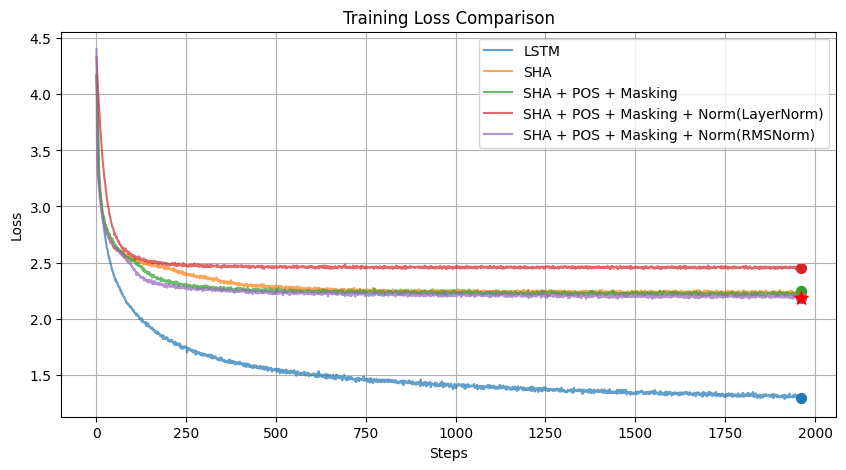

In [36]:
train_and_test("SHA + POS + Masking + Norm(RMSNorm)", start_text)

While RMSNorm hasn't shown a large improvement at this stage, it is expected to have a more significant impact on larger models.

Its effectiveness becomes more pronounced as the model size and complexity increase. We'll see its benefits in later stages with more advanced architectures.

## SHA + POS + Masking + Norm(RMSNorm) + Residual

In [37]:
import torch
import torch.nn.functional as F

class SingleHeadAttention(nn.Module):
    def __init__(self, d_model, seq_length):
        super(SingleHeadAttention, self).__init__()
        self.d_model = d_model
        self.seq_length = seq_length

        self.query = nn.Linear(d_model, d_model, bias=False)
        self.key = nn.Linear(d_model, d_model, bias=False)
        self.value = nn.Linear(d_model, d_model, bias=False)
        self.fc_out = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x, mask=None):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Scaled dot-product attention
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_model ** 0.5)

        # look-ahead masking!
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))

        attention_probs = F.softmax(attention_scores, dim=-1)
        attention_output = torch.matmul(attention_probs, V)

        return self.fc_out(attention_output)


# Custom RMSNorm to match LLaMA 1 official implementation
class RMSNorm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super(RMSNorm, self).__init__()
        self.weight = nn.Parameter(torch.ones(d_model))
        self.eps = eps

    def _norm(self, x):
        # Compute variance and apply reciprocal square root for RMS normalization
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        # Convert to float32 for precision, then back to original dtype
        output = self._norm(x.float()).type_as(x)
        return output * self.weight


# LLaMA Decoder Layer
class LLaMADecoderLayer(nn.Module):
    def __init__(self, embedding_dim, seq_length):
        super(LLaMADecoderLayer, self).__init__()
        self.attention = SingleHeadAttention(embedding_dim, seq_length)
        self.rmsnorm1 = RMSNorm(embedding_dim) # pre-norm
        self.rmsnorm2 = RMSNorm(embedding_dim) # post-norm

    def forward(self, x, mask):
        # Pre-Norm
        normed_x = self.rmsnorm1(x)

        # Attention
        attention_output = self.attention(normed_x, mask)

        # Residual connection
        x = x + attention_output

        # Post-Norm
        normed_x = self.rmsnorm2(x)

        # Residual Connection
        x = x + normed_x

        return x

class LLaMAModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, seq_length):
        super(LLaMAModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.layer = LLaMADecoderLayer(embedding_dim, seq_length)
        self.fc_out = nn.Linear(embedding_dim, vocab_size, bias=False) # lm_head

        self.rmsnorm_f = RMSNorm(embedding_dim) # final_norm

        # Learnable Positional Embedding
        self.positional_embedding = nn.Embedding(seq_length, embedding_dim)

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        # Add positional embeddings to input embeddings
        seq_positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)  # Create position indices
        x = x + self.positional_embedding(seq_positions)

        # Look-Ahead Masking
        seq_length = x.size(1)
        mask = torch.tril(torch.ones(seq_length, seq_length)).to(x.device)

        x = self.layer(x, mask)

        # final norm
        x = self.rmsnorm_f(x)

        logits = self.fc_out(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
            return logits, loss
        return logits, None


Epoch 1/1
Epoch 1, Step 10, Batch 10/1961, Loss: 3.1944
Epoch 1, Step 20, Batch 20/1961, Loss: 2.9747
Epoch 1, Step 30, Batch 30/1961, Loss: 2.8380
Epoch 1, Step 40, Batch 40/1961, Loss: 2.7219
Epoch 1, Step 50, Batch 50/1961, Loss: 2.6913
Epoch 1, Step 60, Batch 60/1961, Loss: 2.6331
Epoch 1, Step 70, Batch 70/1961, Loss: 2.5782
Epoch 1, Step 80, Batch 80/1961, Loss: 2.5770
Epoch 1, Step 90, Batch 90/1961, Loss: 2.5340
Epoch 1, Step 100, Batch 100/1961, Loss: 2.5228
Epoch 1, Step 110, Batch 110/1961, Loss: 2.5042
Epoch 1, Step 120, Batch 120/1961, Loss: 2.4844
Epoch 1, Step 130, Batch 130/1961, Loss: 2.4586
Epoch 1, Step 140, Batch 140/1961, Loss: 2.4163
Epoch 1, Step 150, Batch 150/1961, Loss: 2.4015
Epoch 1, Step 160, Batch 160/1961, Loss: 2.3353
Epoch 1, Step 170, Batch 170/1961, Loss: 2.3088
Epoch 1, Step 180, Batch 180/1961, Loss: 2.2658
Epoch 1, Step 190, Batch 190/1961, Loss: 2.2491
Epoch 1, Step 200, Batch 200/1961, Loss: 2.2278
Epoch 1, Step 210, Batch 210/1961, Loss: 2.2112


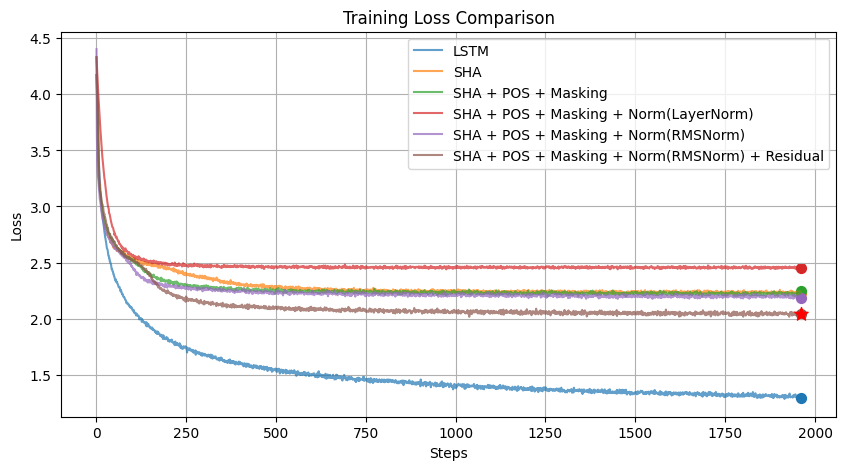

In [38]:
train_and_test("SHA + POS + Masking + Norm(RMSNorm) + Residual", start_text)

Residual connections help prevent the degradation of information as it passes through multiple layers.

By adding the input directly to the output of certain layers (e.g., attention and feed-forward layers), we ensure that important information isn't lost during the transformation process.


## SHA + POS + Masking + RMSNorm + Residual + FeedForward(Original)

In the original transformer architecture, the feed-forward network consisted of a simple projection up to a higher dimensional space, followed by a projection back down. Typically, the up-projection dimension is four times the input dimension. This basic feed-forward architecture provides powerful feature mixing.

In [39]:
import torch
import torch.nn.functional as F

class SingleHeadAttention(nn.Module):
    def __init__(self, d_model, seq_length):
        super(SingleHeadAttention, self).__init__()
        self.d_model = d_model
        self.seq_length = seq_length

        self.query = nn.Linear(d_model, d_model, bias=False)
        self.key = nn.Linear(d_model, d_model, bias=False)
        self.value = nn.Linear(d_model, d_model, bias=False)
        self.fc_out = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x, mask=None):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Scaled dot-product attention
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_model ** 0.5)

        # look-ahead masking!
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))

        attention_probs = F.softmax(attention_scores, dim=-1)
        attention_output = torch.matmul(attention_probs, V)

        return self.fc_out(attention_output)


# Custom RMSNorm to match LLaMA 1 official implementation
class RMSNorm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super(RMSNorm, self).__init__()
        self.weight = nn.Parameter(torch.ones(d_model))
        self.eps = eps

    def _norm(self, x):
        # Compute variance and apply reciprocal square root for RMS normalization
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        # Convert to float32 for precision, then back to original dtype
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

# Original Feed-Forward Network
class FeedForward(nn.Module):
    def __init__(self, d_model):
        super(FeedForward, self).__init__()
        up_hidden_dim = d_model * 4
        self.up_proj = nn.Linear(d_model, up_hidden_dim, bias=False)
        self.down_proj = nn.Linear(up_hidden_dim, d_model, bias=False)
        self.act_fn = F.relu

    def forward(self, x):
        return self.down_proj(self.act_fn(self.up_proj(x)))

# LLaMA Decoder Layer
class LLaMADecoderLayer(nn.Module):
    def __init__(self, embedding_dim, seq_length):
        super(LLaMADecoderLayer, self).__init__()
        self.attention = SingleHeadAttention(embedding_dim, seq_length)
        self.rmsnorm1 = RMSNorm(embedding_dim) # pre-norm
        self.rmsnorm2 = RMSNorm(embedding_dim) # post-norm
        self.feed_forward = FeedForward(embedding_dim)

    def forward(self, x, mask):
        # Pre-Norm
        normed_x = self.rmsnorm1(x)

        # Attention
        attention_output = self.attention(normed_x, mask)

        # Residual connection
        x = x + attention_output

        # Post-Norm
        normed_x = self.rmsnorm2(x)

        feed_forward_output = self.feed_forward(normed_x)

        # Residual Connection
        return x + feed_forward_output

class LLaMAModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, seq_length):
        super(LLaMAModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.layer = LLaMADecoderLayer(embedding_dim, seq_length)
        self.fc_out = nn.Linear(embedding_dim, vocab_size, bias=False) # lm_head

        self.rmsnorm_f = RMSNorm(embedding_dim) # final_norm

        # Learnable Positional Embedding
        self.positional_embedding = nn.Embedding(seq_length, embedding_dim)

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        # Add positional embeddings to input embeddings
        seq_positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)  # Create position indices
        x = x + self.positional_embedding(seq_positions)

        # Look-Ahead Masking
        seq_length = x.size(1)
        mask = torch.tril(torch.ones(seq_length, seq_length)).to(x.device)

        x = self.layer(x, mask)

        # final norm
        x = self.rmsnorm_f(x)

        logits = self.fc_out(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
            return logits, loss
        return logits, None


Epoch 1/1
Epoch 1, Step 10, Batch 10/1961, Loss: 2.9611
Epoch 1, Step 20, Batch 20/1961, Loss: 2.7189
Epoch 1, Step 30, Batch 30/1961, Loss: 2.6047
Epoch 1, Step 40, Batch 40/1961, Loss: 2.5556
Epoch 1, Step 50, Batch 50/1961, Loss: 2.4912
Epoch 1, Step 60, Batch 60/1961, Loss: 2.4302
Epoch 1, Step 70, Batch 70/1961, Loss: 2.3559
Epoch 1, Step 80, Batch 80/1961, Loss: 2.2890
Epoch 1, Step 90, Batch 90/1961, Loss: 2.2589
Epoch 1, Step 100, Batch 100/1961, Loss: 2.2147
Epoch 1, Step 110, Batch 110/1961, Loss: 2.1802
Epoch 1, Step 120, Batch 120/1961, Loss: 2.1482
Epoch 1, Step 130, Batch 130/1961, Loss: 2.1235
Epoch 1, Step 140, Batch 140/1961, Loss: 2.1085
Epoch 1, Step 150, Batch 150/1961, Loss: 2.0793
Epoch 1, Step 160, Batch 160/1961, Loss: 2.0561
Epoch 1, Step 170, Batch 170/1961, Loss: 2.0489
Epoch 1, Step 180, Batch 180/1961, Loss: 2.0167
Epoch 1, Step 190, Batch 190/1961, Loss: 2.0086
Epoch 1, Step 200, Batch 200/1961, Loss: 1.9910
Epoch 1, Step 210, Batch 210/1961, Loss: 1.9712


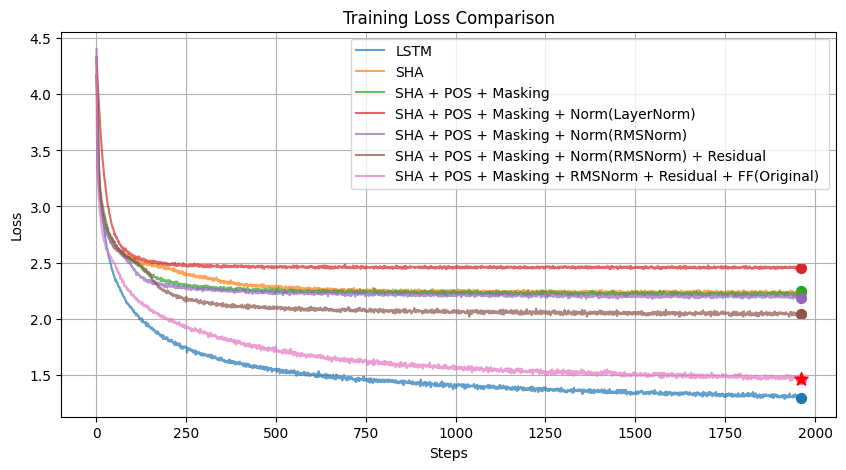

In [40]:
train_and_test("SHA + POS + Masking + RMSNorm + Residual + FF(Original) ", start_text)

Introducing the feed-forward network brings the performance closer to that of the LSTM model. The network now has a mechanism for better mixing information across dimensions, resulting in improved predictions.

## SHA + POS + Masking + RMSNorm + Residual + FeedForward(Gating)

LLaMA uses a more advanced feed-forward mechanism called SwiGLU, which incorporates explicit gating and SiLU activations. This design is more efficient in handling non-linearities and enhances model expressiveness. We will now switch to this feed-forward method to observe its impact.

In [41]:
import torch
import torch.nn.functional as F

class SingleHeadAttention(nn.Module):
    def __init__(self, d_model, seq_length):
        super(SingleHeadAttention, self).__init__()
        self.d_model = d_model
        self.seq_length = seq_length

        self.query = nn.Linear(d_model, d_model, bias=False)
        self.key = nn.Linear(d_model, d_model, bias=False)
        self.value = nn.Linear(d_model, d_model, bias=False)
        self.fc_out = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x, mask=None):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Scaled dot-product attention
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_model ** 0.5)

        # look-ahead masking!
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))

        attention_probs = F.softmax(attention_scores, dim=-1)
        attention_output = torch.matmul(attention_probs, V)

        return self.fc_out(attention_output)


# Custom RMSNorm to match LLaMA 1 official implementation
class RMSNorm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super(RMSNorm, self).__init__()
        self.weight = nn.Parameter(torch.ones(d_model))
        self.eps = eps

    def _norm(self, x):
        # Compute variance and apply reciprocal square root for RMS normalization
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        # Convert to float32 for precision, then back to original dtype
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

# Feed-Forward Network with gating
import math
class FeedForward(nn.Module):
    def __init__(self, d_model, multiple_of):
        super(FeedForward, self).__init__()
        up_hidden_dim = multiple_of * math.ceil((d_model * 4 * 2 / 3) / multiple_of)
        self.gate_proj = nn.Linear(d_model, up_hidden_dim, bias=False)
        self.up_proj = nn.Linear(d_model, up_hidden_dim, bias=False)
        self.down_proj = nn.Linear(up_hidden_dim, d_model, bias=False)
        self.act_fn = F.silu  # SiLU activation

    def forward(self, x):
        return self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))

# LLaMA Decoder Layer
class LLaMADecoderLayer(nn.Module):
    def __init__(self, embedding_dim, multiple_of, seq_length):
        super(LLaMADecoderLayer, self).__init__()
        self.attention = SingleHeadAttention(embedding_dim, seq_length)
        self.rmsnorm1 = RMSNorm(embedding_dim) # pre-norm
        self.rmsnorm2 = RMSNorm(embedding_dim) # post-norm

        self.feed_forward = FeedForward(embedding_dim, multiple_of)


    def forward(self, x, mask):
        # Pre-Norm
        normed_x = self.rmsnorm1(x)

        # Attention
        attention_output = self.attention(normed_x, mask)

        # Residual connection
        x = x + attention_output

        # Post-Norm
        normed_x = self.rmsnorm2(x)

        feed_forward_output = self.feed_forward(normed_x)

        # Residual Connection
        return x + feed_forward_output


class LLaMAModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, seq_length, multiple_of):
        super(LLaMAModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.layer = LLaMADecoderLayer(embedding_dim, multiple_of, seq_length)
        self.fc_out = nn.Linear(embedding_dim, vocab_size, bias=False) # lm_head

        self.rmsnorm_f = RMSNorm(embedding_dim) # final_norm

        # Learnable Positional Embedding
        self.positional_embedding = nn.Embedding(seq_length, embedding_dim)


    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        # Add positional embeddings to input embeddings
        seq_positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)  # Create position indices
        x = x + self.positional_embedding(seq_positions)

        # Look-Ahead Masking
        seq_length = x.size(1)
        mask = torch.tril(torch.ones(seq_length, seq_length)).to(x.device)

        x = self.layer(x, mask)

        # final norm
        x = self.rmsnorm_f(x)

        logits = self.fc_out(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
            return logits, loss
        return logits, None


In [42]:
def train_and_test(model_desc, start_text, multiple_of):
    # Initialize the model
    model_llama = LLaMAModel(vocab_size, EMBEDDING_DIM, SEQUENCE_LENGTH, multiple_of).to(device)

    # Use the same optimizer and criterion
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model_llama.parameters(), lr=LEARNING_RATE)

    # Train the model
    trained_model, train_losses_df, val_losses_df = train_model(
        model_llama, train_loader, val_loader, criterion, optimizer, device, EPOCHS
    )

    # Generate text
    generated_text = generate_text_attention(trained_model, char_to_idx, idx_to_char, start_text, device)
    print(f"Generated text [{start_text}]:")
    print("-"*50)
    print(generated_text)

    add_loss_to_comparison(model_desc, train_losses_df, val_losses_df)

    # Plot loss comparisons including this model
    plot_loss_comparisons()

In the LLaMA 1 implementation, the up-projection dimension is not simply calculated as 4 times the hidden dimension, as seen in the original transformers. Instead, LLaMA uses a more efficient approach where the up-projection dimension is a multiple of a specific value, often 256, to optimize for GPU performance.

The formula for calculating the up-projection dimension is as follows:

$$
up\_hidden\_dim = multiple\_of \times \left\lceil \frac{hidden\_dim \times 4 \times \frac{2}{3}}{multiple\_of} \right\rceil
$$

For example, if the hidden dimension is 4096 and the `multiple_of` value is 256, the calculation is:

$$
up\_hidden\_dim = 256 \times \left\lceil \frac{4096 \times 4 \times \frac{2}{3}}{256} \right\rceil
$$

This results in:

$$
up\_hidden\_dim = 256 \times \left\lceil \frac{10922.6667}{256} \right\rceil = 256 \times 43 = 11008
$$

#### Why use `multiple_of = 256`?

- **GPU Efficiency**:
  - Modern hardware like GPUs and TPUs are optimized for matrix operations when the tensor dimensions are multiples of powers of 2, such as 32, 64, 128, or 256.
  - Rounding dimensions to multiples of 256 ensures memory alignment and maximizes parallel processing efficiency, reducing wasted memory bandwidth and improving throughput during matrix computations.

In this example, instead of using LLaMA 1's typical value of 256 for `multiple_of`, we use a smaller value, such as 8, for demonstration purposes. This allows us to explore the architecture with limited computational resources while maintaining the structure of the model.





Epoch 1/1
Epoch 1, Step 10, Batch 10/1961, Loss: 2.9902
Epoch 1, Step 20, Batch 20/1961, Loss: 2.7215
Epoch 1, Step 30, Batch 30/1961, Loss: 2.5865
Epoch 1, Step 40, Batch 40/1961, Loss: 2.5213
Epoch 1, Step 50, Batch 50/1961, Loss: 2.4819
Epoch 1, Step 60, Batch 60/1961, Loss: 2.4317
Epoch 1, Step 70, Batch 70/1961, Loss: 2.3763
Epoch 1, Step 80, Batch 80/1961, Loss: 2.2965
Epoch 1, Step 90, Batch 90/1961, Loss: 2.2335
Epoch 1, Step 100, Batch 100/1961, Loss: 2.1821
Epoch 1, Step 110, Batch 110/1961, Loss: 2.1313
Epoch 1, Step 120, Batch 120/1961, Loss: 2.1040
Epoch 1, Step 130, Batch 130/1961, Loss: 2.0802
Epoch 1, Step 140, Batch 140/1961, Loss: 2.0380
Epoch 1, Step 150, Batch 150/1961, Loss: 2.0244
Epoch 1, Step 160, Batch 160/1961, Loss: 1.9898
Epoch 1, Step 170, Batch 170/1961, Loss: 1.9938
Epoch 1, Step 180, Batch 180/1961, Loss: 1.9648
Epoch 1, Step 190, Batch 190/1961, Loss: 1.9453
Epoch 1, Step 200, Batch 200/1961, Loss: 1.9170
Epoch 1, Step 210, Batch 210/1961, Loss: 1.9235


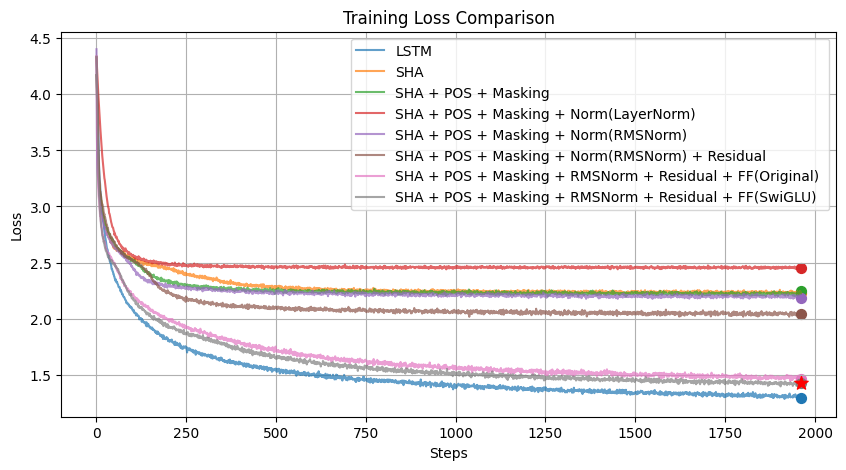

In [43]:
multiple_of = 8   # roughly dim * 1/16
train_and_test("SHA + POS + Masking + RMSNorm + Residual + FF(SwiGLU)", start_text, multiple_of)

With SwiGLU, we achieve performance similar to simpler models. However, its true strength becomes apparent in larger models and datasets. As model scale increases, SwiGLU outperforms simpler feed-forward mechanisms. Next, we'll swap out the learnable positional encoding for RoPE.

## SHA + POS(ROPE) + Masking + RMSNorm + Residual + FeedForward(Gating)

Rotary Position Embedding (RoPE) is an advanced method for injecting positional information into the model. It provides a more efficient and scalable way to handle positional information compared to learnable embeddings, especially for longer sequences. RoPE also improves the model's ability to generalize across different sequence lengths.

In [44]:
import torch
import torch.nn.functional as F

# RoPE: Rotary Position Embedding function
def apply_rotary_pos_emb(q, k, sin, cos):
    q_rot = (q * cos) + (rotate_half(q) * sin)
    k_rot = (k * cos) + (rotate_half(k) * sin)
    return q_rot, k_rot

def rotate_half(x):
    x1, x2 = x.chunk(2, dim=-1)
    return torch.cat((-x2, x1), dim=-1)

# in case of single-head head_dim = dim
def build_rope_cache(seq_len, head_dim, device):
    inv_freq = 1.0 / (10000 ** (torch.arange(0, head_dim, 2).float().to(device) / head_dim))
    t = torch.arange(seq_len, device=device).float()
    freqs = torch.einsum('i,j->ij', t, inv_freq)
    emb = torch.cat((freqs, freqs), dim=-1)
    sin, cos = emb.sin(), emb.cos()
    return sin, cos

# Single-Head Attention (Very Basic)
class SingleHeadAttention(nn.Module):
    def __init__(self, d_model, seq_length):
        super(SingleHeadAttention, self).__init__()
        self.d_model = d_model
        self.seq_length = seq_length

        self.query = nn.Linear(d_model, d_model, bias=False)
        self.key = nn.Linear(d_model, d_model, bias=False)
        self.value = nn.Linear(d_model, d_model, bias=False)
        self.fc_out = nn.Linear(d_model, d_model, bias=False)

        # Build RoPE cache
        self.sin, self.cos = build_rope_cache(seq_length, d_model, torch.device('cpu'))

    def forward(self, x, mask=None):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Apply RoPE to Q and K
        batch_size, seq_length, _ = x.size()
        sin, cos = self.sin[:seq_length, :].to(x.device), self.cos[:seq_length, :].to(x.device)
        Q_rot, K_rot = apply_rotary_pos_emb(Q, K, sin, cos)

        # Scaled dot-product attention
        attention_scores = torch.matmul(Q_rot, K_rot.transpose(-2, -1)) / (self.d_model ** 0.5)

        # look-ahead masking!
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))

        attention_probs = F.softmax(attention_scores, dim=-1)
        attention_output = torch.matmul(attention_probs, V)

        return self.fc_out(attention_output)


# Custom RMSNorm to match LLaMA 1 official implementation
class RMSNorm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super(RMSNorm, self).__init__()
        self.weight = nn.Parameter(torch.ones(d_model))
        self.eps = eps

    def _norm(self, x):
        # Compute variance and apply reciprocal square root for RMS normalization
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        # Convert to float32 for precision, then back to original dtype
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

# Feed-Forward Network with gating
import math
class FeedForward(nn.Module):
    def __init__(self, d_model, multiple_of):
        super(FeedForward, self).__init__()
        up_hidden_dim = multiple_of * math.ceil((d_model * 4 * 2 / 3) / multiple_of)
        self.gate_proj = nn.Linear(d_model, up_hidden_dim, bias=False)
        self.up_proj = nn.Linear(d_model, up_hidden_dim, bias=False)
        self.down_proj = nn.Linear(up_hidden_dim, d_model, bias=False)
        self.act_fn = F.silu  # SiLU activation

    def forward(self, x):
        return self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))

# LLaMA Decoder Layer
class LLaMADecoderLayer(nn.Module):
    def __init__(self, embedding_dim, multiple_of, seq_length):
        super(LLaMADecoderLayer, self).__init__()
        self.attention = SingleHeadAttention(embedding_dim, seq_length)
        self.rmsnorm1 = RMSNorm(embedding_dim) # pre-norm
        self.rmsnorm2 = RMSNorm(embedding_dim) # post-norm

        self.feed_forward = FeedForward(embedding_dim, multiple_of)


    def forward(self, x, mask):
        # Pre-Norm
        normed_x = self.rmsnorm1(x)

        # Attention
        attention_output = self.attention(normed_x, mask)

        # Residual connection
        x = x + attention_output

        # Post-Norm
        normed_x = self.rmsnorm2(x)

        feed_forward_output = self.feed_forward(normed_x)

        # Residual Connection
        return x + feed_forward_output


class LLaMAModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, seq_length, multiple_of):
        super(LLaMAModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.layer = LLaMADecoderLayer(embedding_dim, multiple_of, seq_length)
        self.fc_out = nn.Linear(embedding_dim, vocab_size, bias=False) # lm_head

        self.rmsnorm_f = RMSNorm(embedding_dim) # final_norm

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        # Look-Ahead Masking
        seq_length = x.size(1)
        mask = torch.tril(torch.ones(seq_length, seq_length)).to(x.device)

        x = self.layer(x, mask)

        # final norm
        x = self.rmsnorm_f(x)

        logits = self.fc_out(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
            return logits, loss
        return logits, None


Epoch 1/1
Epoch 1, Step 10, Batch 10/1961, Loss: 2.7944
Epoch 1, Step 20, Batch 20/1961, Loss: 2.5771
Epoch 1, Step 30, Batch 30/1961, Loss: 2.4922
Epoch 1, Step 40, Batch 40/1961, Loss: 2.4311
Epoch 1, Step 50, Batch 50/1961, Loss: 2.3624
Epoch 1, Step 60, Batch 60/1961, Loss: 2.3241
Epoch 1, Step 70, Batch 70/1961, Loss: 2.2819
Epoch 1, Step 80, Batch 80/1961, Loss: 2.2662
Epoch 1, Step 90, Batch 90/1961, Loss: 2.2217
Epoch 1, Step 100, Batch 100/1961, Loss: 2.2045
Epoch 1, Step 110, Batch 110/1961, Loss: 2.1954
Epoch 1, Step 120, Batch 120/1961, Loss: 2.1677
Epoch 1, Step 130, Batch 130/1961, Loss: 2.1446
Epoch 1, Step 140, Batch 140/1961, Loss: 2.1457
Epoch 1, Step 150, Batch 150/1961, Loss: 2.1057
Epoch 1, Step 160, Batch 160/1961, Loss: 2.0914
Epoch 1, Step 170, Batch 170/1961, Loss: 2.0989
Epoch 1, Step 180, Batch 180/1961, Loss: 2.0600
Epoch 1, Step 190, Batch 190/1961, Loss: 2.0618
Epoch 1, Step 200, Batch 200/1961, Loss: 2.0490
Epoch 1, Step 210, Batch 210/1961, Loss: 2.0217


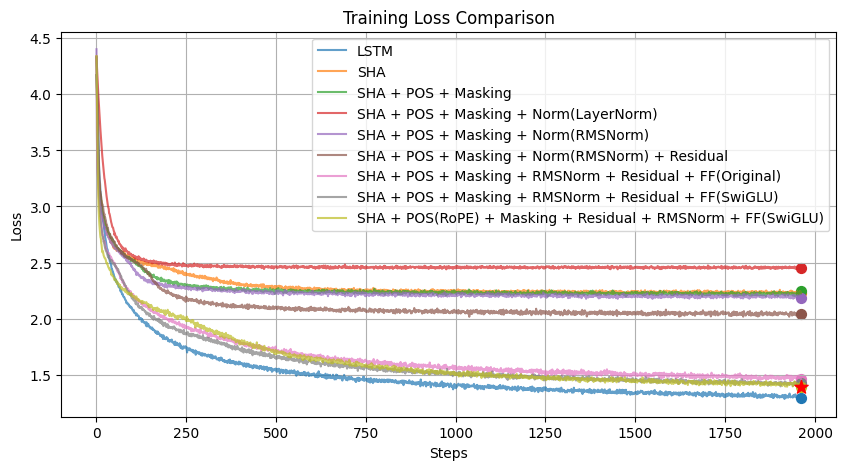

In [45]:
multiple_of = 8   # roughly dim * 1/16
train_and_test("SHA + POS(RoPE) + Masking + Residual + RMSNorm + FF(SwiGLU)", start_text, multiple_of)

After implementing RoPE, we haven't seen improvements compared to the Original Positional Encoding. In fact, performance has slightly decreased. This makes sense because RoPE was primarily designed for modeling extremely long documents, making it somewhat of an overkill mechanism for our current data modeling needs.

-----

We now conclude our single-head attention series and move on to multi-head attention, which significantly boosts performance.

Multi-head attention allows the model to focus on different parts of the input sequence simultaneously, providing a richer representation of the data and improving learning efficiency.



# Multihead Attention

In [46]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import math

# RoPE: Rotary Position Embedding function
def apply_rotary_pos_emb(q, k, sin, cos):
    q_rot = (q * cos) + (rotate_half(q) * sin)
    k_rot = (k * cos) + (rotate_half(k) * sin)
    return q_rot, k_rot

def rotate_half(x):
    x1, x2 = x.chunk(2, dim=-1)
    return torch.cat((-x2, x1), dim=-1)

def build_rope_cache(seq_len, head_dim, device):
    inv_freq = 1.0 / (10000 ** (torch.arange(0, head_dim, 2).float().to(device) / head_dim))
    t = torch.arange(seq_len, device=device).float()
    freqs = torch.einsum('i,j->ij', t, inv_freq)
    emb = torch.cat((freqs, freqs), dim=-1)
    sin, cos = emb.sin(), emb.cos()
    return sin, cos

# Custom RMSNorm to match LLaMA 1 official implementation
class RMSNorm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super(RMSNorm, self).__init__()
        self.weight = nn.Parameter(torch.ones(d_model))
        self.eps = eps

    def _norm(self, x):
        # Compute variance and apply reciprocal square root for RMS normalization
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        # Convert to float32 for precision, then back to original dtype
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

# Feed-Forward Network with gating
class FeedForward(nn.Module):
    def __init__(self, d_model, multiple_of):
        super(FeedForward, self).__init__()
        up_hidden_dim = multiple_of * math.ceil((d_model * 4 * 2 / 3) / multiple_of)
        self.gate_proj = nn.Linear(d_model, up_hidden_dim, bias=False)
        self.up_proj = nn.Linear(d_model, up_hidden_dim, bias=False)
        self.down_proj = nn.Linear(up_hidden_dim, d_model, bias=False)
        self.act_fn = F.silu  # SiLU activation

    def forward(self, x):
        return self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))

# Multi-Head Attention with Causal Masking and RoPE
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, seq_length):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads
        self.seq_length = seq_length

        self.query = nn.Linear(d_model, d_model, bias=False)
        self.key = nn.Linear(d_model, d_model, bias=False)
        self.value = nn.Linear(d_model, d_model, bias=False)
        self.fc_out = nn.Linear(d_model, d_model, bias=False)

        # Build RoPE cache
        self.sin, self.cos = build_rope_cache(seq_length, self.head_dim, torch.device('cpu'))

    def forward(self, x, mask=None):
        batch_size, seq_length, _ = x.size()
        Q = self.query(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.key(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.value(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)

        # Apply RoPE to Q and K
        sin, cos = self.sin[:seq_length, :].to(x.device), self.cos[:seq_length, :].to(x.device)
        Q_rot, K_rot = apply_rotary_pos_emb(Q, K, sin, cos)

        # Scaled dot-product attention
        attention_scores = torch.matmul(Q_rot, K_rot.transpose(-2, -1)) / (self.head_dim ** 0.5)
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))

        attention_probs = F.softmax(attention_scores, dim=-1)
        attention_output = torch.matmul(attention_probs, V)

        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        return self.fc_out(attention_output)

# LLaMA Decoder Layer with Multi-Head Attention and RoPE
class LLaMADecoderLayer(nn.Module):
    def __init__(self, embedding_dim, multiple_of, num_heads, seq_length):
        super(LLaMADecoderLayer, self).__init__()
        self.rmsnorm1 = RMSNorm(embedding_dim)
        self.attention = MultiHeadAttention(embedding_dim, num_heads, seq_length)
        self.rmsnorm2 = RMSNorm(embedding_dim)
        self.feed_forward = FeedForward(embedding_dim, multiple_of)

    def forward(self, x, mask):
        normed_x = self.rmsnorm1(x)
        attention_output = self.attention(normed_x, mask)
        x = x + attention_output  # Residual connection
        normed_x = self.rmsnorm2(x)
        feed_forward_output = self.feed_forward(normed_x)
        return x + feed_forward_output  # Residual connection

class LLaMAModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, seq_length, num_heads, multiple_of):
        super(LLaMAModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.layer = LLaMADecoderLayer(embedding_dim, multiple_of, num_heads, seq_length)
        self.rmsnorm_f = RMSNorm(embedding_dim)
        self.fc_out = nn.Linear(embedding_dim, vocab_size, bias=False)

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        seq_length = x.size(1)
        mask = torch.tril(torch.ones(seq_length, seq_length)).to(x.device)

        x = self.layer(x, mask)

        x = self.rmsnorm_f(x)
        logits = self.fc_out(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
            return logits, loss
        return logits, None

In [47]:
def train_and_test(model_desc, start_text, multiple_of, num_heads):
    # Initialize the model
    model_llama = LLaMAModel(vocab_size, EMBEDDING_DIM, SEQUENCE_LENGTH, num_heads, multiple_of).to(device)

    # Use the same optimizer and criterion
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model_llama.parameters(), lr=LEARNING_RATE)

    # Train the model
    trained_model, train_losses_df, val_losses_df = train_model(
        model_llama, train_loader, val_loader, criterion, optimizer, device, EPOCHS
    )

    # Generate text
    generated_text = generate_text_attention(trained_model, char_to_idx, idx_to_char, start_text, device)
    print(f"Generated text [{start_text}]:")
    print("-"*50)
    print(generated_text)

    add_loss_to_comparison(model_desc, train_losses_df, val_losses_df)

    # Plot loss comparisons including this model
    plot_loss_comparisons()

Epoch 1/1
Epoch 1, Step 10, Batch 10/1961, Loss: 2.8107
Epoch 1, Step 20, Batch 20/1961, Loss: 2.5709
Epoch 1, Step 30, Batch 30/1961, Loss: 2.4600
Epoch 1, Step 40, Batch 40/1961, Loss: 2.3571
Epoch 1, Step 50, Batch 50/1961, Loss: 2.3043
Epoch 1, Step 60, Batch 60/1961, Loss: 2.2461
Epoch 1, Step 70, Batch 70/1961, Loss: 2.1762
Epoch 1, Step 80, Batch 80/1961, Loss: 2.1523
Epoch 1, Step 90, Batch 90/1961, Loss: 2.0784
Epoch 1, Step 100, Batch 100/1961, Loss: 2.0316
Epoch 1, Step 110, Batch 110/1961, Loss: 2.0127
Epoch 1, Step 120, Batch 120/1961, Loss: 1.9633
Epoch 1, Step 130, Batch 130/1961, Loss: 1.9462
Epoch 1, Step 140, Batch 140/1961, Loss: 1.8970
Epoch 1, Step 150, Batch 150/1961, Loss: 1.8842
Epoch 1, Step 160, Batch 160/1961, Loss: 1.8640
Epoch 1, Step 170, Batch 170/1961, Loss: 1.8115
Epoch 1, Step 180, Batch 180/1961, Loss: 1.7818
Epoch 1, Step 190, Batch 190/1961, Loss: 1.7808
Epoch 1, Step 200, Batch 200/1961, Loss: 1.7632
Epoch 1, Step 210, Batch 210/1961, Loss: 1.7448


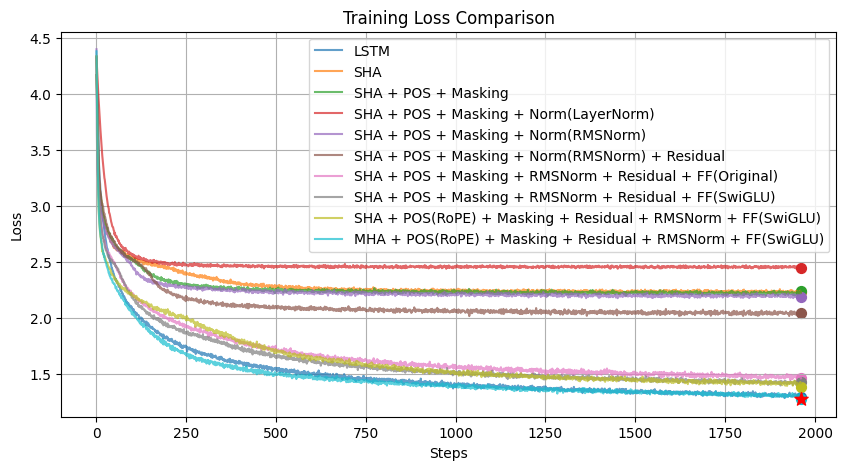

In [48]:
multiple_of = 8   # roughly dim * 1/16
num_heads = 8
train_and_test("MHA + POS(RoPE) + Masking + Residual + RMSNorm + FF(SwiGLU)", start_text, multiple_of, num_heads)

As expected, multi-head attention dramatically improves the performance. The loss curve becomes much smoother, and the generated text is much more fluent and coherent. Multi-head attention allows the model to better capture complex relationships within the sequence.

# Multi-Layer

Real-world transformers often have dozens of layers, with models like GPT-3 and LLaMA featuring as many as 32 layers or more. The true power of transformers comes from stacking multiple layers, which helps capture deeper patterns and relationships within the data. In this step, we extend our model to a multi-layer architecture.

And one more change will be added. Previously, since there was only a single layer, the RoPE cache was placed inside the MHA. However, in the case of multiple layers, the RoPE cache is now created only once at the beginning and reused across all layers.

In [49]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import math

# RoPE: Rotary Position Embedding function
def apply_rotary_pos_emb(q, k, sin, cos):
    q_rot = (q * cos) + (rotate_half(q) * sin)
    k_rot = (k * cos) + (rotate_half(k) * sin)
    return q_rot, k_rot

def rotate_half(x):
    x1, x2 = x.chunk(2, dim=-1)
    return torch.cat((-x2, x1), dim=-1)


# Building the RoPE cache once, to be shared across layers
class RoPECache:
    def __init__(self, seq_len, head_dim, device):
        self.sin, self.cos = self.build_rope_cache(seq_len, head_dim, device)

    @staticmethod
    def build_rope_cache(seq_len, head_dim, device):
        inv_freq = 1.0 / (10000 ** (torch.arange(0, head_dim, 2).float().to(device) / head_dim))
        t = torch.arange(seq_len, device=device).float()
        freqs = torch.einsum('i,j->ij', t, inv_freq)
        emb = torch.cat((freqs, freqs), dim=-1)
        sin, cos = emb.sin(), emb.cos()
        return sin, cos

# Custom RMSNorm to match LLaMA 1 official implementation
class RMSNorm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super(RMSNorm, self).__init__()
        self.weight = nn.Parameter(torch.ones(d_model))
        self.eps = eps

    def _norm(self, x):
        # Compute variance and apply reciprocal square root for RMS normalization
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        # Convert to float32 for precision, then back to original dtype
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

# Feed-Forward Network with gating
class FeedForward(nn.Module):
    def __init__(self, d_model, multiple_of):
        super(FeedForward, self).__init__()
        up_hidden_dim = multiple_of * math.ceil((d_model * 4 * 2 / 3) / multiple_of)
        self.gate_proj = nn.Linear(d_model, up_hidden_dim, bias=False)
        self.up_proj = nn.Linear(d_model, up_hidden_dim, bias=False)
        self.down_proj = nn.Linear(up_hidden_dim, d_model, bias=False)
        self.act_fn = F.silu  # SiLU activation

    def forward(self, x):
        return self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))

# Multi-Head Attention with Causal Masking and RoPE
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, seq_length, rope_cache):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads
        self.seq_length = seq_length

        self.query = nn.Linear(d_model, d_model, bias=False)
        self.key = nn.Linear(d_model, d_model, bias=False)
        self.value = nn.Linear(d_model, d_model, bias=False)
        self.fc_out = nn.Linear(d_model, d_model, bias=False)

        # Use the shared RoPE cache
        self.rope_cache = rope_cache

    def forward(self, x, mask=None):
        batch_size, seq_length, _ = x.size()
        Q = self.query(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.key(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.value(x).view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)

        # Apply RoPE to Q and K
        sin, cos = self.rope_cache.sin[:seq_length, :].to(x.device), self.rope_cache.cos[:seq_length, :].to(x.device)
        Q_rot, K_rot = apply_rotary_pos_emb(Q, K, sin, cos)

        # Scaled dot-product attention
        attention_scores = torch.matmul(Q_rot, K_rot.transpose(-2, -1)) / (self.head_dim ** 0.5)
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))

        attention_probs = F.softmax(attention_scores, dim=-1)
        attention_output = torch.matmul(attention_probs, V)

        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        return self.fc_out(attention_output)

# LLaMA Decoder Layer with Multi-Head Attention and RoPE
class LLaMADecoderLayer(nn.Module):
    def __init__(self, embedding_dim, multiple_of, num_heads, seq_length, rms_norm_eps, rope_cache):
        super(LLaMADecoderLayer, self).__init__()
        self.rmsnorm1 = RMSNorm(embedding_dim, rms_norm_eps)
        self.attention = MultiHeadAttention(embedding_dim, num_heads, seq_length, rope_cache)
        self.rmsnorm2 = RMSNorm(embedding_dim, rms_norm_eps)
        self.feed_forward = FeedForward(embedding_dim, multiple_of)

    def forward(self, x, mask):
        normed_x = self.rmsnorm1(x)
        attention_output = self.attention(normed_x, mask)
        x = x + attention_output  # Residual connection
        normed_x = self.rmsnorm2(x)
        feed_forward_output = self.feed_forward(normed_x)
        return x + feed_forward_output  # Residual connection

# LLaMA Model with RoPE and Multi-Layer
class LLaMAModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, seq_length, num_heads, num_layers, multiple_of, rms_norm_eps=1e-6):
        super(LLaMAModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Initialize the shared RoPE cache once
        rope_cache = RoPECache(seq_length, embedding_dim // num_heads, torch.device('cpu'))

        self.layers = nn.ModuleList([LLaMADecoderLayer(embedding_dim, multiple_of, num_heads, seq_length, rms_norm_eps, rope_cache) for _ in range(num_layers)])
        self.rmsnorm_f = RMSNorm(embedding_dim, rms_norm_eps)
        self.fc_out = nn.Linear(embedding_dim, vocab_size, bias=False)

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        seq_length = x.size(1)
        mask = torch.tril(torch.ones(seq_length, seq_length)).to(x.device)

        for layer in self.layers:
            x = layer(x, mask)

        x = self.rmsnorm_f(x)
        logits = self.fc_out(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
            return logits, loss
        return logits, None

In [50]:
def train_and_test(model_desc, start_text, multiple_of, num_heads, num_layers):
    # Initialize the model
    model_llama = LLaMAModel(vocab_size, EMBEDDING_DIM, SEQUENCE_LENGTH, num_heads, num_layers, multiple_of).to(device)

    # Use the same optimizer and criterion
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model_llama.parameters(), lr=LEARNING_RATE)

    # Train the model
    trained_model, train_losses_df, val_losses_df = train_model(
        model_llama, train_loader, val_loader, criterion, optimizer, device, EPOCHS
    )

    # Generate text
    generated_text = generate_text_attention(trained_model, char_to_idx, idx_to_char, start_text, device)
    print(f"Generated text [{start_text}]:")
    print("-"*50)
    print(generated_text)

    add_loss_to_comparison(model_desc, train_losses_df, val_losses_df)

    # Plot loss comparisons including this model
    plot_loss_comparisons()

Epoch 1/1
Epoch 1, Step 10, Batch 10/1961, Loss: 2.5972
Epoch 1, Step 20, Batch 20/1961, Loss: 2.4247
Epoch 1, Step 30, Batch 30/1961, Loss: 2.3040
Epoch 1, Step 40, Batch 40/1961, Loss: 2.1605
Epoch 1, Step 50, Batch 50/1961, Loss: 2.0462
Epoch 1, Step 60, Batch 60/1961, Loss: 1.9647
Epoch 1, Step 70, Batch 70/1961, Loss: 1.8625
Epoch 1, Step 80, Batch 80/1961, Loss: 1.7928
Epoch 1, Step 90, Batch 90/1961, Loss: 1.7087
Epoch 1, Step 100, Batch 100/1961, Loss: 1.6513
Epoch 1, Step 110, Batch 110/1961, Loss: 1.6033
Epoch 1, Step 120, Batch 120/1961, Loss: 1.5837
Epoch 1, Step 130, Batch 130/1961, Loss: 1.5288
Epoch 1, Step 140, Batch 140/1961, Loss: 1.4960
Epoch 1, Step 150, Batch 150/1961, Loss: 1.5038
Epoch 1, Step 160, Batch 160/1961, Loss: 1.4683
Epoch 1, Step 170, Batch 170/1961, Loss: 1.4373
Epoch 1, Step 180, Batch 180/1961, Loss: 1.4179
Epoch 1, Step 190, Batch 190/1961, Loss: 1.3930
Epoch 1, Step 200, Batch 200/1961, Loss: 1.4012
Epoch 1, Step 210, Batch 210/1961, Loss: 1.3996


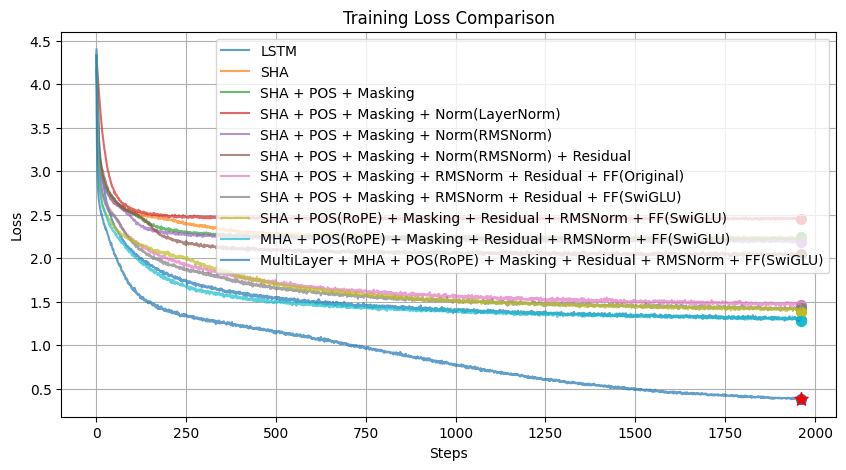

In [51]:
multiple_of = 8   # roughly dim * 1/16
num_heads = 8
num_layers = 6

train_and_test("MultiLayer + MHA + POS(RoPE) + Masking + Residual + RMSNorm + FF(SwiGLU)", start_text, multiple_of, num_heads, num_layers)

With multiple layers, we see a significant improvement in the loss curve and generated text quality. The model is now capable of producing grammatically correct sentences with more coherent meaning. This demonstrates the power of deep transformers, which become more effective as the number of layers increases.

----

# Comparing Hugging Face's LLaMA with Our Custom Implementation

Finally, we compare our custom LLaMA implementation with the Hugging Face LLaMA model. This test ensures that our model structure and weight initialization are correct, and that our custom implementation produces the same outputs as the official version.

In [52]:
import torch
from transformers import LlamaForCausalLM, LlamaTokenizer

model_name = "huggyllama/llama-7b"
hf_model = LlamaForCausalLM.from_pretrained(model_name).to('cpu')
tokenizer = LlamaTokenizer.from_pretrained(model_name)

[2025-03-12 05:05:48,679] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
2025-03-12 05:05:50.262614: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-12 05:05:51.068052: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.28k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message


In [53]:
hf_model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-06)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-06)
      

In [54]:
hf_model.config

LlamaConfig {
  "_name_or_path": "huggyllama/llama-7b",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 2048,
  "max_sequence_length": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "float16",
  "transformers_version": "4.44.0",
  "use_cache": true,
  "vocab_size": 32000
}

In [55]:
# Example usage:
vocab_size = hf_model.config.vocab_size
embedding_dim = hf_model.config.hidden_size
seq_length = hf_model.config.max_position_embeddings
num_heads = hf_model.config.num_attention_heads
num_layers = hf_model.config.num_hidden_layers
multiple_of = 256
rms_norm_eps = hf_model.config.rms_norm_eps

my_llama = LLaMAModel(vocab_size, embedding_dim, seq_length, num_heads, num_layers, multiple_of, rms_norm_eps).to(torch.device('cpu'))
print(my_llama)

LLaMAModel(
  (embedding): Embedding(32000, 4096)
  (layers): ModuleList(
    (0-31): 32 x LLaMADecoderLayer(
      (rmsnorm1): RMSNorm()
      (attention): MultiHeadAttention(
        (query): Linear(in_features=4096, out_features=4096, bias=False)
        (key): Linear(in_features=4096, out_features=4096, bias=False)
        (value): Linear(in_features=4096, out_features=4096, bias=False)
        (fc_out): Linear(in_features=4096, out_features=4096, bias=False)
      )
      (rmsnorm2): RMSNorm()
      (feed_forward): FeedForward(
        (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
        (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
        (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
      )
    )
  )
  (rmsnorm_f): RMSNorm()
  (fc_out): Linear(in_features=4096, out_features=32000, bias=False)
)


We begin by copying all weights from the Hugging Face model to our custom
implementation. This ensures that both models share the same parameters. Then, we compare the logits from each model to verify that our implementation behaves identically to the official LLaMA model.

In [56]:
import torch

# Function to copy all weights for the custom model from Hugging Face model
def copy_all_weights(hf_model, custom_model):
    # Copy embedding weights
    custom_model.embedding.weight.data.copy_(hf_model.model.embed_tokens.weight.data)

    # Iterate over all decoder layers
    for i in range(len(custom_model.layers)):
        custom_layer = custom_model.layers[i]
        hf_layer = hf_model.model.layers[i]

        # Copy attention weights (q_proj, k_proj, v_proj, o_proj)
        custom_layer.attention.query.weight.data.copy_(hf_layer.self_attn.q_proj.weight.data)
        custom_layer.attention.key.weight.data.copy_(hf_layer.self_attn.k_proj.weight.data)
        custom_layer.attention.value.weight.data.copy_(hf_layer.self_attn.v_proj.weight.data)
        custom_layer.attention.fc_out.weight.data.copy_(hf_layer.self_attn.o_proj.weight.data)

        # Copy LayerNorm weights (Pre and Post attention)
        custom_layer.rmsnorm1.weight.data.copy_(hf_layer.input_layernorm.weight.data)
        custom_layer.rmsnorm2.weight.data.copy_(hf_layer.post_attention_layernorm.weight.data)

        # Copy Feed-Forward weights (gate_proj, up_proj, down_proj)
        custom_layer.feed_forward.gate_proj.weight.data.copy_(hf_layer.mlp.gate_proj.weight.data)
        custom_layer.feed_forward.up_proj.weight.data.copy_(hf_layer.mlp.up_proj.weight.data)
        custom_layer.feed_forward.down_proj.weight.data.copy_(hf_layer.mlp.down_proj.weight.data)

    # Copy final LayerNorm and output projection weights
    custom_model.rmsnorm_f.weight.data.copy_(hf_model.model.norm.weight.data)

    # Copy the final projection (LM head) weights
    custom_model.fc_out.weight.data.copy_(hf_model.lm_head.weight.data)

    print("All weights copied successfully.")

# Hugging Face model's logits
def get_hf_logits(hf_model, input_ids):
    # Run forward pass for Hugging Face model and get the logits
    with torch.no_grad():
        hf_logits = hf_model(input_ids).logits
    return hf_logits

# Custom model's logits
def get_custom_logits(custom_model, input_ids):
    # Run the custom model to get the logits
    logits, _ = custom_model(input_ids)
    return logits

# Compare the logits
def compare_logits(hf_logits, custom_logits, atol=1e-6):
    print("\nHugging Face Logits (Subset):", hf_logits[0, :5])
    print("\nCustom Model Logits (Subset):", custom_logits[0, :5])

    if torch.allclose(hf_logits, custom_logits, atol=atol):
        print("Logits match within tolerance", atol, "!")
    else:
        print("Logits do not match!")
        diff = (hf_logits - custom_logits).abs()
        max_diff = diff.max()
        print("Max difference:", max_diff)

        # Print detailed differences where the mismatch occurs
        mismatched_positions = (diff > atol).nonzero(as_tuple=True)
        print("Mismatched positions:", mismatched_positions)
        print("Hugging Face Logits at mismatch:", hf_logits[mismatched_positions])
        print("Custom Model Logits at mismatch:", custom_logits[mismatched_positions])

# Main function to copy, extract, and compare final logits
def test_logits_comparison(hf_model, custom_model, text, tokenizer):
    # Tokenize input text
    input_ids = tokenizer(text, return_tensors="pt")["input_ids"]

    # Step 1: Copy all weights from Hugging Face to custom model
    copy_all_weights(hf_model, custom_model)

    # Step 2: Get logits from both models
    hf_logits = get_hf_logits(hf_model, input_ids)
    custom_logits = get_custom_logits(custom_model, input_ids)

    # Step 3: Compare the logits
    compare_logits(hf_logits, custom_logits)

# Example usage:
# Assume hf_model is already loaded as Hugging Face model and tokenizer is loaded
test_logits_comparison(hf_model, my_llama, "This is a test sentence.", tokenizer)

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


All weights copied successfully.

Hugging Face Logits (Subset): tensor([[-12.7783, -28.6372,   0.9082,  ...,  -7.6488,  -8.5626,  -7.6832],
        [-12.3429, -15.6131,  -0.2792,  ...,  -7.9353,  -8.3205,  -6.9708],
        [ -8.0558, -11.4901,   1.7421,  ...,  -2.7486,  -5.5838,  -2.1781],
        [-12.5170, -16.3852,  -3.0466,  ...,  -9.4720,  -9.6039,  -8.0278],
        [-12.0348, -19.4677,   1.7724,  ..., -10.3636,  -7.7492,  -8.4502]])

Custom Model Logits (Subset): tensor([[-12.7783, -28.6372,   0.9082,  ...,  -7.6488,  -8.5626,  -7.6832],
        [-12.3429, -15.6131,  -0.2792,  ...,  -7.9353,  -8.3205,  -6.9708],
        [ -8.0558, -11.4901,   1.7421,  ...,  -2.7486,  -5.5838,  -2.1781],
        [-12.5170, -16.3852,  -3.0466,  ...,  -9.4720,  -9.6039,  -8.0278],
        [-12.0348, -19.4677,   1.7724,  ..., -10.3636,  -7.7492,  -8.4502]],
       grad_fn=<SliceBackward0>)
Logits do not match!
Max difference: tensor(3.2902e-05, grad_fn=<MaxBackward1>)
Mismatched positions: (tensor(

### Comparison in a High-Precision Environment (64-bit Floating Point)

In 32-bit or 16-bit environments, small numerical errors accumulate during operations like normalization, scaling, or activation functions due to rounding. Even if two architectures are identical, these small differences can lead to slightly different outputs. As we saw earlier in the 32-bit environment, the results from the two models were extremely close, but there were still minor differences due to these accumulated errors.

To conclusively demonstrate that the two architectures are truly the same, we move to a 64-bit floating-point environment. In 64-bit precision, very small values are calculated and preserved with much higher accuracy, eliminating the numerical errors caused by rounding in lower precision environments.

In [57]:
import copy
hf_model_64 = copy.deepcopy(hf_model).double()
my_llama_64 = copy.deepcopy(my_llama).double()

In [58]:
import torch

# Function to copy all weights for the custom model from Hugging Face model
def copy_all_weights(hf_model, custom_model):
    # Copy embedding weights
    custom_model.embedding.weight.data.copy_(hf_model.model.embed_tokens.weight.data)

    # Iterate over all decoder layers
    for i in range(len(custom_model.layers)):
        custom_layer = custom_model.layers[i]
        hf_layer = hf_model.model.layers[i]

        # Copy attention weights (q_proj, k_proj, v_proj, o_proj)
        custom_layer.attention.query.weight.data.copy_(hf_layer.self_attn.q_proj.weight.data)
        custom_layer.attention.key.weight.data.copy_(hf_layer.self_attn.k_proj.weight.data)
        custom_layer.attention.value.weight.data.copy_(hf_layer.self_attn.v_proj.weight.data)
        custom_layer.attention.fc_out.weight.data.copy_(hf_layer.self_attn.o_proj.weight.data)

        # Copy LayerNorm weights (Pre and Post attention)
        custom_layer.rmsnorm1.weight.data.copy_(hf_layer.input_layernorm.weight.data)
        custom_layer.rmsnorm2.weight.data.copy_(hf_layer.post_attention_layernorm.weight.data)

        # Copy Feed-Forward weights (gate_proj, up_proj, down_proj)
        custom_layer.feed_forward.gate_proj.weight.data.copy_(hf_layer.mlp.gate_proj.weight.data)
        custom_layer.feed_forward.up_proj.weight.data.copy_(hf_layer.mlp.up_proj.weight.data)
        custom_layer.feed_forward.down_proj.weight.data.copy_(hf_layer.mlp.down_proj.weight.data)

    # Copy final LayerNorm and output projection weights
    custom_model.rmsnorm_f.weight.data.copy_(hf_model.model.norm.weight.data)

    # Copy the final projection (LM head) weights
    custom_model.fc_out.weight.data.copy_(hf_model.lm_head.weight.data)

    print("All weights copied successfully.")

# Hugging Face model's logits in 64-bit precision
def get_hf_logits_64(hf_model, input_ids):
    # Run forward pass for Hugging Face model and get the logits in double precision
    with torch.no_grad():
        hf_logits = hf_model(input_ids).logits.double()
    return hf_logits

# Custom model's logits in 64-bit precision
def get_custom_logits_64(custom_model, input_ids):
    # Run the custom model to get the logits in double precision
    logits, _ = custom_model(input_ids)
    return logits.double()

# Compare the logits with 64-bit precision
def compare_logits_64(hf_logits, custom_logits, atol=1e-8):
    print("\nHugging Face Logits (Subset):", hf_logits[0, :5])
    print("\nCustom Model Logits (Subset):", custom_logits[0, :5])

    if torch.allclose(hf_logits, custom_logits, atol=atol):
        print("Logits match within tolerance", atol, "!")
    else:
        print("Logits do not match!")
        diff = (hf_logits - custom_logits).abs()
        max_diff = diff.max()
        print("Max difference:", max_diff)

        # Print detailed differences where the mismatch occurs
        mismatched_positions = (diff > atol).nonzero(as_tuple=True)
        print("Mismatched positions:", mismatched_positions)
        print("Hugging Face Logits at mismatch:", hf_logits[mismatched_positions])
        print("Custom Model Logits at mismatch:", custom_logits[mismatched_positions])

# Main function to copy, extract, and compare final logits in 64-bit precision
def test_logits_comparison_64(hf_model_64, custom_model_64, text, tokenizer):
    # Tokenize input text and keep input_ids as torch.int64 and double precision
    input_ids = tokenizer(text, return_tensors="pt")["input_ids"].to(torch.int64)

    # Step 1: Copy all weights from Hugging Face to custom model
    copy_all_weights(hf_model_64, custom_model_64)

    # Step 2: Get logits from both models
    hf_logits = get_hf_logits_64(hf_model_64, input_ids)
    custom_logits = get_custom_logits_64(custom_model_64, input_ids)

    # Step 3: Compare the logits in double precision
    compare_logits_64(hf_logits, custom_logits)

# Example usage:
# Assume hf_model_64 is the Hugging Face model in double precision and my_model_64 is your custom model in double precision
test_logits_comparison_64(hf_model_64, my_llama_64, "This is a test sentence.", tokenizer)


All weights copied successfully.

Hugging Face Logits (Subset): tensor([[-12.7783, -28.6372,   0.9082,  ...,  -7.6488,  -8.5626,  -7.6832],
        [-12.3429, -15.6130,  -0.2792,  ...,  -7.9353,  -8.3205,  -6.9708],
        [ -8.0558, -11.4901,   1.7421,  ...,  -2.7486,  -5.5838,  -2.1781],
        [-12.5170, -16.3852,  -3.0466,  ...,  -9.4720,  -9.6039,  -8.0278],
        [-12.0348, -19.4677,   1.7724,  ..., -10.3636,  -7.7492,  -8.4502]],
       dtype=torch.float64)

Custom Model Logits (Subset): tensor([[-12.7783, -28.6372,   0.9082,  ...,  -7.6488,  -8.5626,  -7.6832],
        [-12.3429, -15.6130,  -0.2792,  ...,  -7.9353,  -8.3205,  -6.9708],
        [ -8.0558, -11.4901,   1.7421,  ...,  -2.7486,  -5.5838,  -2.1781],
        [-12.5170, -16.3852,  -3.0466,  ...,  -9.4720,  -9.6039,  -8.0278],
        [-12.0348, -19.4677,   1.7724,  ..., -10.3636,  -7.7492,  -8.4502]],
       dtype=torch.float64, grad_fn=<SliceBackward0>)
Logits match within tolerance 1e-08 !


After conducting the comparison, we observe that the outputs of our custom LLaMA implementation match those of the Hugging Face model exactly. This confirms that our implementation is correct, and that it behaves identically to the official LLaMA model.

# Conclusion

In this notebook, we successfully implemented a custom version of the LLaMA model, progressively building from simple components to a complete, high-performing architecture. Starting with a baseline LSTM model, we gradually introduced key features of transformers such as attention, positional encoding, normalization, and residual connections. We incorporated advanced techniques like SwiGLU and RoPE, ultimately scaling the model to multiple layers and heads.

Our final model closely matches the Hugging Face LLaMA implementation, confirming the correctness of our approach. The key takeaways are the importance of scalability, attention mechanisms, and careful architectural design when building state-of-the-art language models.
